Student: Michael Menjares

# Part 1&2

**Part 1**

Create a notebook where you have uploaded and shown the .head() of each of your data sets. For each of the proposed datasets, include the following information in text cells:

1. Source of data

2. Brief description of data

3. What is the target?

4. What does one row represent? (A person?  A business?  An event? A product?)

5. Is this a classification or regression problem?

6. How many features does the data have?

7. How many rows are in the dataset?

8. What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?

Create a NEW GitHub repository for this project, with a readme, and add your notebook to that new repository.


**Part 2**
- Deleted unnecessary columns.
- Deleted duplicate rows.
- Identified and addressed missing values.
- Identified and corrected inconsistencies in data for categorical values (i.e. Cat, cat, cats).
- Produced univariate visuals for the target and all features.
- Identified outliers.
- Clearly commented all of your cleaning steps and described any decisions you made.
- Commit your file to your Github repository and submit the link below.

Dataset contains 14 features such as individual’s education level, age, gender, occupation and explores the possibility in predicting whether an individual will make more than $50k in annual income based on these features. The dataset has 48,842 rows and each row represents an individual. This is a classification problem since the target is the income column which has two classes: <=50K and >50K. As far as a challenge, some of the data has a '?' which is pressumed to be a NaN or missing value.

source: https://www.kaggle.com/datasets/wenruliu/adult-income-dataset


## Import

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_selector, make_column_transformer

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from sklearn.metrics import (roc_auc_score, ConfusionMatrixDisplay, 
                             PrecisionRecallDisplay, RocCurveDisplay, 
                             f1_score, accuracy_score, precision_score,
                             recall_score, classification_report)

In [3]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vStYRY6SXzBSdI6psSMrZLiTc2vteGZbPv57tyZaE4csMWbQSa9MJuRXJJXo2kYa-hFuppkA8mtfhli/pub?gid=488173702&single=true&output=csv'
df_original = pd.read_csv(url)
df = df_original.copy()
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


## Data Manipulation

In [5]:
#remove rows that have '?' anywhere in df
value = '?'
df = df[~df.isin([value]).any(axis=1)]

In [6]:
#remove rows that have 'Without-pay' anywhere in df
value = 'Without-pay'
df = df[~df.isin([value]).any(axis=1)]

In [7]:
df['workclass'].value_counts()

Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Name: workclass, dtype: int64

In [8]:
not_gov = ['Private','Self-emp-not-inc','Self-emp-inc']
gov = ['Local-gov','State-gov','Federal-gov']
df['workclass'][df['workclass'].isin(not_gov)] = 0
df['workclass'][df['workclass'].isin(gov)] = 1
df.rename(columns={'workclass': 'IsGov'}, inplace=True)

C:\Users\mmenj\AppData\Local\Temp\ipykernel_42360\2222147724.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['workclass'][df['workclass'].isin(gov)] = 1


In [9]:
df['IsGov'].value_counts(dropna=False)

0    38749
1     6452
Name: IsGov, dtype: int64

In [10]:
df['IsGov'] = df['IsGov'].astype(int)

In [110]:
df['age'] = (df['age'] // 10) * 10

## Split

In [111]:
target = ['income']
drop_cols = ['fnlwgt','education']

drop_cols = target + drop_cols

df[target] = df[target].replace({'>50K': 1, '<=50K': 0})


y = df[target]
X = df.drop(columns = drop_cols)

X['net-capital'] = X['capital-gain'] - X['capital-loss']
X = X.drop(['capital-gain', 'capital-loss'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(f'Target Values:\n{y.head()}\n\nFeatures:')

X.head()

Target Values:
   income
0       0
1       0
2       1
3       1
5       0

Features:


,age,IsGov,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,net-capital
0,20,0,7,Never-married,Machine-op-inspct,Own-child,Black,Male,40,United-States,0
1,30,0,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,50,United-States,0
2,20,1,12,Married-civ-spouse,Protective-serv,Husband,White,Male,40,United-States,0
3,40,0,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,40,United-States,7688
5,30,0,6,Never-married,Other-service,Not-in-family,White,Male,30,United-States,0


Decided to drop fnlwgt which is a number created by surveyors and felt did not have a correlation to target. Also dropped education column since education num is the same data as education-num but in integer form.

## Clean Data

Duplicates

In [112]:
print(f'{df.duplicated().sum()} duplicates before drop')
df.drop_duplicates(inplace = True)
print(f'Duplicates dropped\n{df.duplicated().sum()} duplicates after drop')

87 duplicates before drop
Duplicates dropped
0 duplicates after drop


Missing Data

In [113]:
print(f'{df.isna().sum().sum()} of the {len(df)} entries have missing values.')
print(f'\nThis is {round(df.isna().sum().sum()/len(df)*100)}% of the entries')
print(f'\nMissing Entries by Column:\n{df.isna().sum()}')

0 of the 45062 entries have missing values.

This is 0% of the entries

Missing Entries by Column:
age                0
IsGov              0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64


even though shows no missing values, a few columns have values marked '?' which is assumed to be unknown or a missing value.

Check Datatypes and Inconsistent Values

In [14]:
print(f'X Data Types:\n\n{X.dtypes}\n')
print(f'y Data Types:\n\n{y.dtypes}')

X Data Types:

age                 int64
IsGov               int32
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
hours-per-week      int64
native-country     object
net-capital         int64
dtype: object

y Data Types:

income    int64
dtype: object


In [15]:
X.head()

,age,IsGov,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,net-capital
0,25,0,7,Never-married,Machine-op-inspct,Own-child,Black,Male,40,United-States,0
1,38,0,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,50,United-States,0
2,28,1,12,Married-civ-spouse,Protective-serv,Husband,White,Male,40,United-States,0
3,44,0,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,40,United-States,7688
5,34,0,6,Never-married,Other-service,Not-in-family,White,Male,30,United-States,0


In [16]:
pd.set_option("display.max_rows", None)
for x in X.columns:
  print(X[x].value_counts(dropna=False), '\n')

36    1283
33    1279
31    1274
35    1272
23    1241
34    1234
37    1229
30    1215
38    1211
28    1198
32    1196
41    1174
39    1168
27    1156
29    1156
40    1144
25    1133
24    1130
42    1113
26    1092
43    1065
46    1061
45    1049
47    1038
44    1035
22    1033
21     934
20     916
19     861
51     834
50     828
48     815
49     810
52     699
18     695
53     689
54     584
55     574
56     534
58     517
57     514
17     493
59     488
60     398
61     394
62     326
64     284
63     280
65     215
66     180
67     179
68     135
69     116
70      96
71      90
72      82
73      82
74      58
75      53
76      46
90      46
77      39
80      29
81      27
78      21
79      20
82      10
83       9
84       9
85       5
88       5
89       1
87       1
86       1
Name: age, dtype: int64 

0    38749
1     6452
Name: IsGov, dtype: int64 

9     14769
10     9896
13     7570
14     2514
11     1959
7      1619
12     1505
6      1223
4       821
15

In [17]:
X.dtypes 

age                 int64
IsGov               int32
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
hours-per-week      int64
native-country     object
net-capital         int64
dtype: object

## EDA

In [18]:
X.describe() 

,age,IsGov,educational-num,hours-per-week,net-capital
count,45201.000000,45201.000000,45201.000000,45201.000000,45201.000000
mean,38.543882,0.142740,10.119002,40.941262,1013.196124
std,13.212842,0.349812,2.553043,12.004178,7532.005106
min,17.000000,0.000000,1.000000,1.000000,-4356.000000
25%,28.000000,0.000000,9.000000,40.000000,0.000000
50%,37.000000,0.000000,10.000000,40.000000,0.000000
75%,47.000000,0.000000,13.000000,45.000000,0.000000
max,90.000000,1.000000,16.000000,99.000000,99999.000000


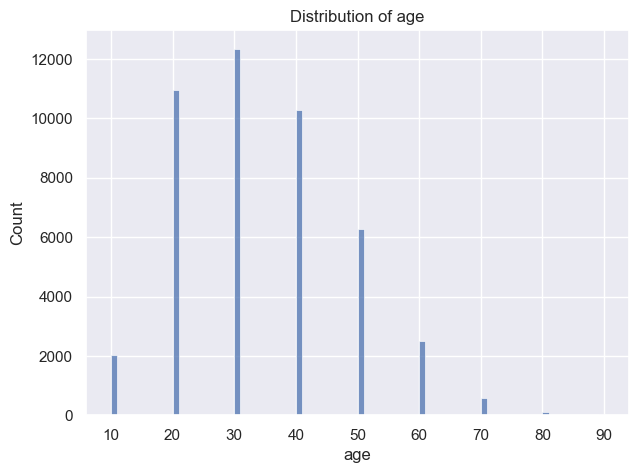

the ages are skewed to the left and peak between 20 and 40 years old


In [115]:
col_name = 'age'
ax = sns.histplot(data = X, x = col_name,bins=range(min(X[col_name]), max(X[col_name]) + 1))
plt.title(f'Distribution of {col_name}')
plt.show()
print(f'the ages are skewed to the left and peak between 20 and 40 years old')

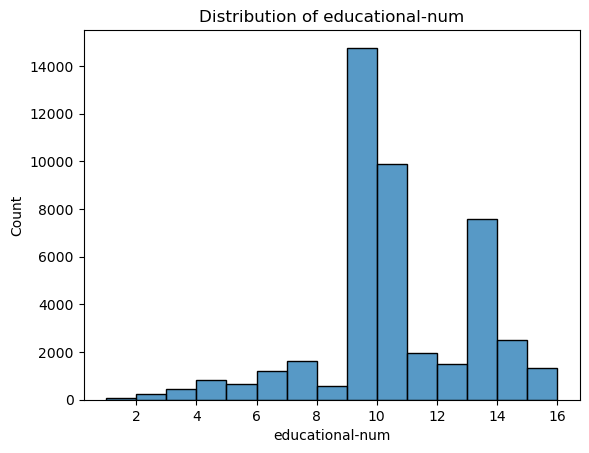

the education levels skew to the right and most frequent levels are 10,11,14 which are some-college, assocociates or vocational, and masters


In [20]:
col_name = 'educational-num'
ax = sns.histplot(data = X, x = col_name,bins=range(min(X[col_name]), max(X[col_name]) + 1))
plt.title(f'Distribution of {col_name}')
plt.show()
print(f'the education levels skew to the right and most frequent levels are 10,11,14 which are some-college, assocociates or vocational, and masters')

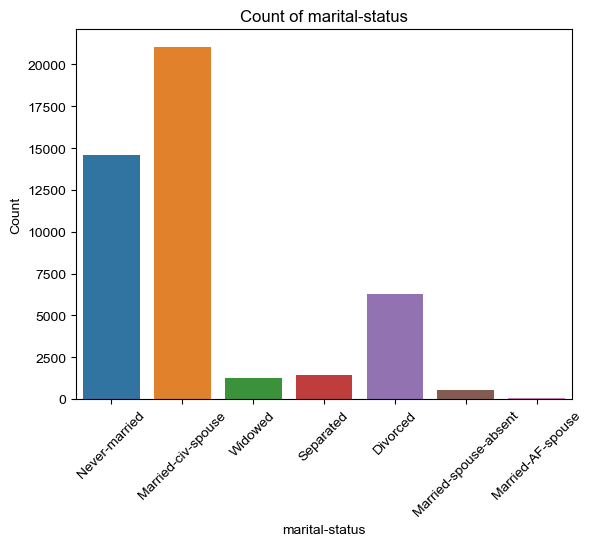

Most are married with a civilian spouse or never married


In [21]:
col_name = 'marital-status'
sns.countplot(x=col_name, data=X)
plt.title(f'Count of {col_name}')
sns.set(rc={'figure.figsize':(7,5)})
plt.xticks(rotation=45, fontsize=10)
plt.xlabel(col_name)
plt.ylabel('Count')
plt.show()
print('Most are married with a civilian spouse or never married')

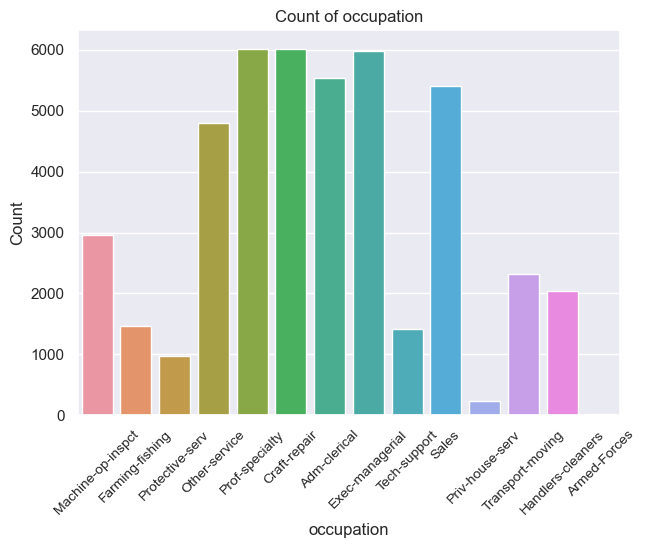

In [22]:
col_name = 'occupation'
sns.countplot(x=col_name, data=X)
plt.title(f'Count of {col_name}')
sns.set(rc={'figure.figsize':(7,5)})
plt.xticks(rotation=45, fontsize=10)
plt.xlabel(col_name)
plt.ylabel('Count')
plt.show()

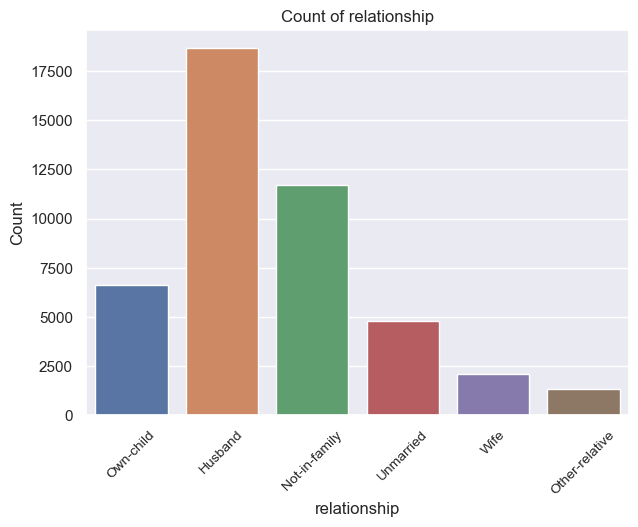

Most common relationship is husband of household or not in family


In [23]:
col_name = 'relationship'
sns.countplot(x=col_name, data=X)
plt.title(f'Count of {col_name}')
sns.set(rc={'figure.figsize':(7,5)})
plt.xticks(rotation=45, fontsize=10)
plt.xlabel(col_name)
plt.ylabel('Count')
plt.show()
print('Most common relationship is husband of household or not in family')

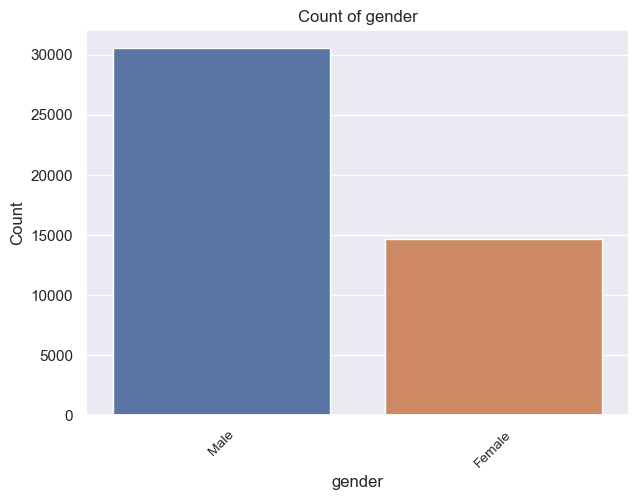

about twice as many males than females in the dataset


In [24]:
col_name = 'gender'
sns.countplot(x=col_name, data=X)
plt.title(f'Count of {col_name}')
sns.set(rc={'figure.figsize':(7,5)})
plt.xticks(rotation=45, fontsize=10)
plt.xlabel(col_name)
plt.ylabel('Count')
plt.show()
print('about twice as many males than females in the dataset')

# Part 3
1. For this part of the project, you will continue your data exploration by:

    - Identifying any moderate or strong correlations between your target and your features and/or between one feature and another using a correlation heatmap.
    - Creating multivariate (multiple variables) exploratory visualizations to further understand your data and search for trends.
    
    
2. Then, choose two visualizations from your analysis that demonstrate key trends you found that will be of interest to a stakeholder. These visuals should be reporting quality with titles, labels, and a short explanation of the trend. Be sure to explain in a text cell the insight associated with each visual. Both of these visualizations should be easily understood by a non-technical audience (Neither of these should be histograms, boxplots, or correlation plots).

    - These plots should be so simple, and so easy to read, that a 6th grader could understand them in less than 10 seconds without asking questions.  They don't need to be fancy, they need to CLEARLY show an interesting trend or correlation between features in your data.

In [25]:
X['net-capital'].value_counts()

 0        39274
 15024      498
 7688       391
 7298       351
-1902       294
-1977       246
 99999      229
-1887       227
 3103       146
 5178       137
 5013       116
 4386       102
 3325        81
 8614        78
 2174        72
-2415        68
-1485        65
-1848        65
 10520       64
 4650        62
-1876        59
-1590        58
-1740        57
 27828       56
 4064        52
 3137        50
-1672        49
 14084       47
 20051       44
 594         42
-1741        42
 3908        41
 6849        41
-1602        40
 13550       40
-1564        40
 2829        40
-2258        39
-1980        36
 14344       34
 4787        34
-1669        34
-1719        33
-1408        32
-2001        32
 1055        31
-2002        31
 3411        30
 3464        30
-2051        29
 2597        29
-1579        29
 4101        28
 2176        28
 2885        28
 2202        27
-1974        27
 4865        24
-2339        24
-1504        23
 2407        23
 9386        23
 1506   

C:\Users\mmenj\AppData\Local\Temp\ipykernel_42360\4293495446.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = X.corr()


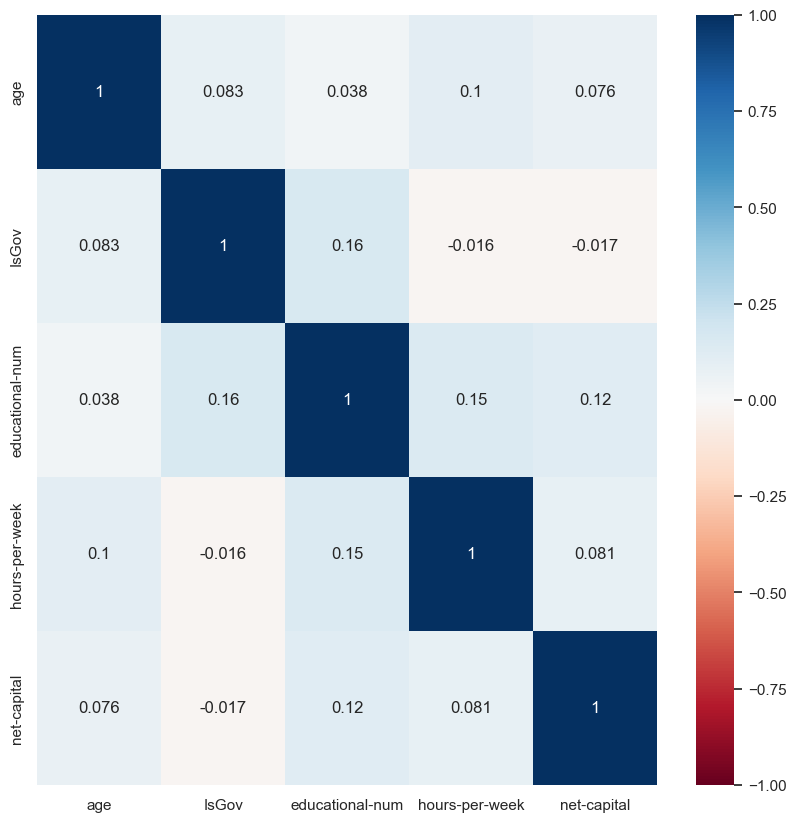

In [26]:
corr = X.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot = True);

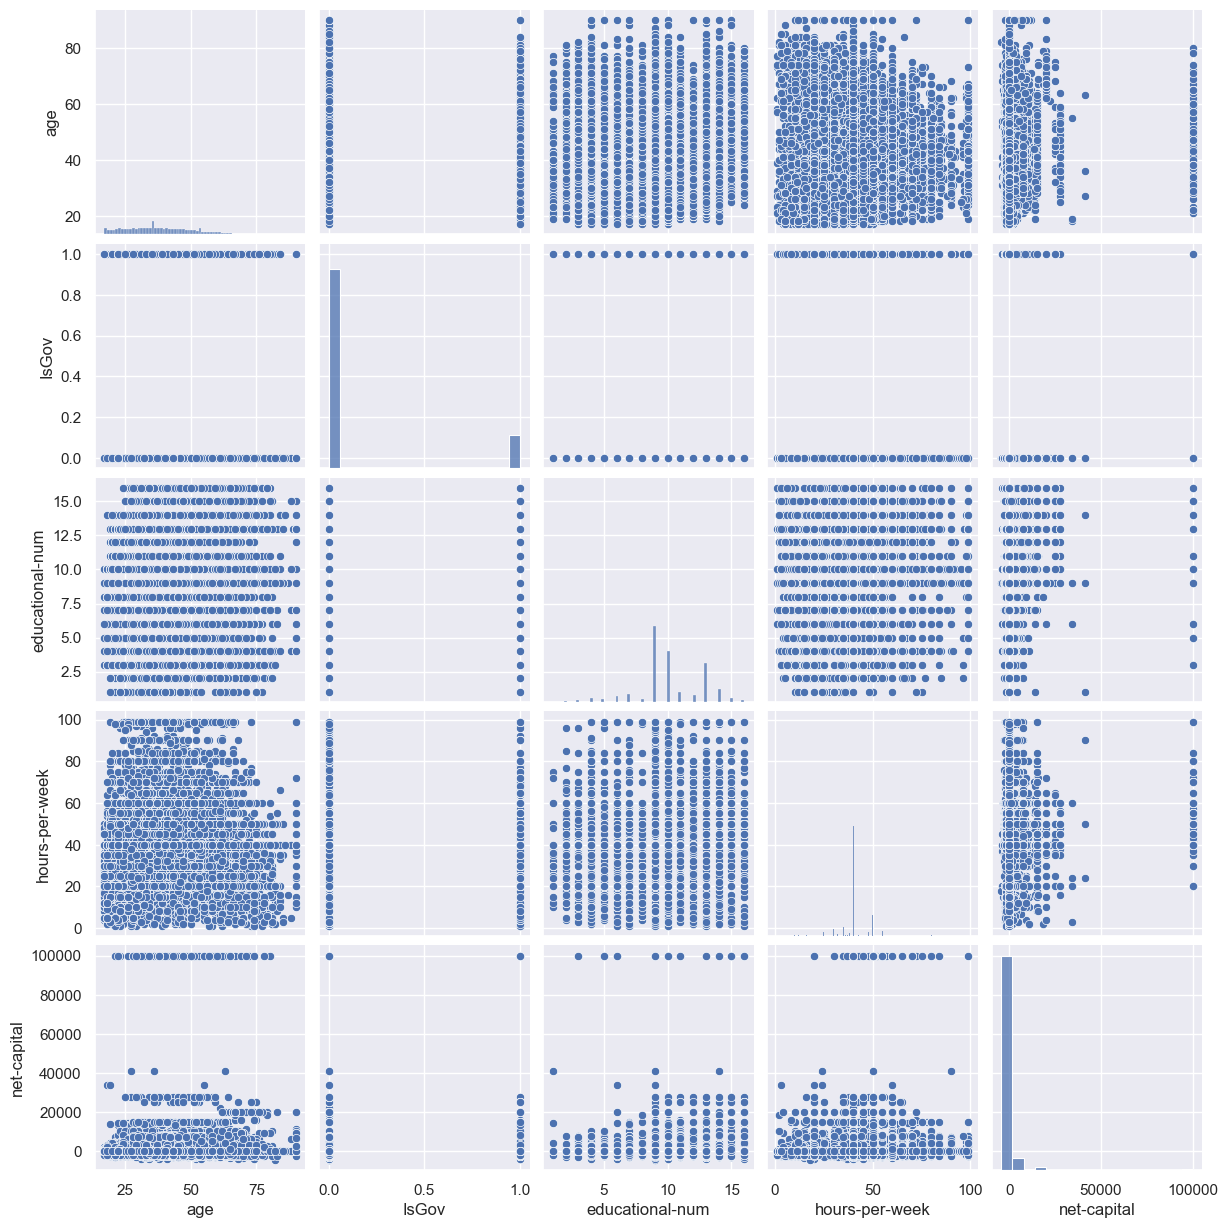

In [27]:
sns.pairplot(X);

No obvious pattern or correlation between columns

In [28]:
def groupby_plot(groupby, groupwhat):
    means = X.groupby(groupby)[groupwhat].mean().sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.barplot(data=X,x=groupby, y = groupwhat, order = means.index)
    plt.xticks()
    ax.set_title(f'Average {groupwhat} vs. {groupby}', fontsize = 20, fontweight = 'bold');
    ax.set_xlabel(groupby, fontsize = 15, fontweight = 'bold')
    ax.set_ylabel(groupwhat, fontsize = 15, fontweight = 'bold');

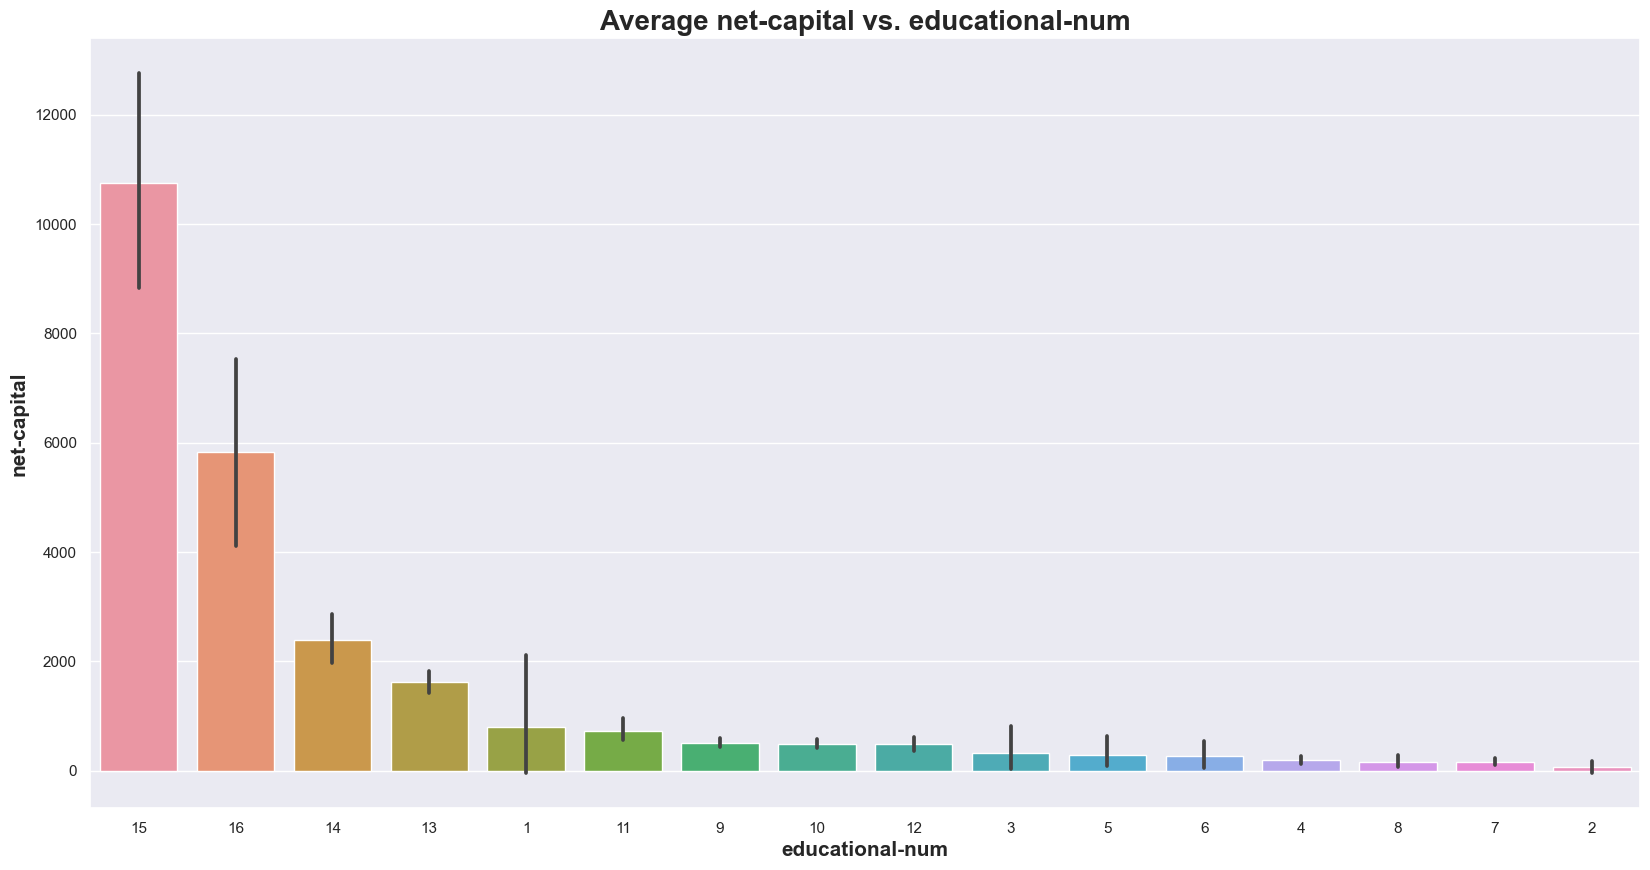

In [29]:
groupby_plot('educational-num','net-capital')

Bachelors or higher (13+) have the top 4 spots for average net capital

In [30]:
plt.savefig('Net_Capital_vs_Education.png')

<Figure size 700x500 with 0 Axes>

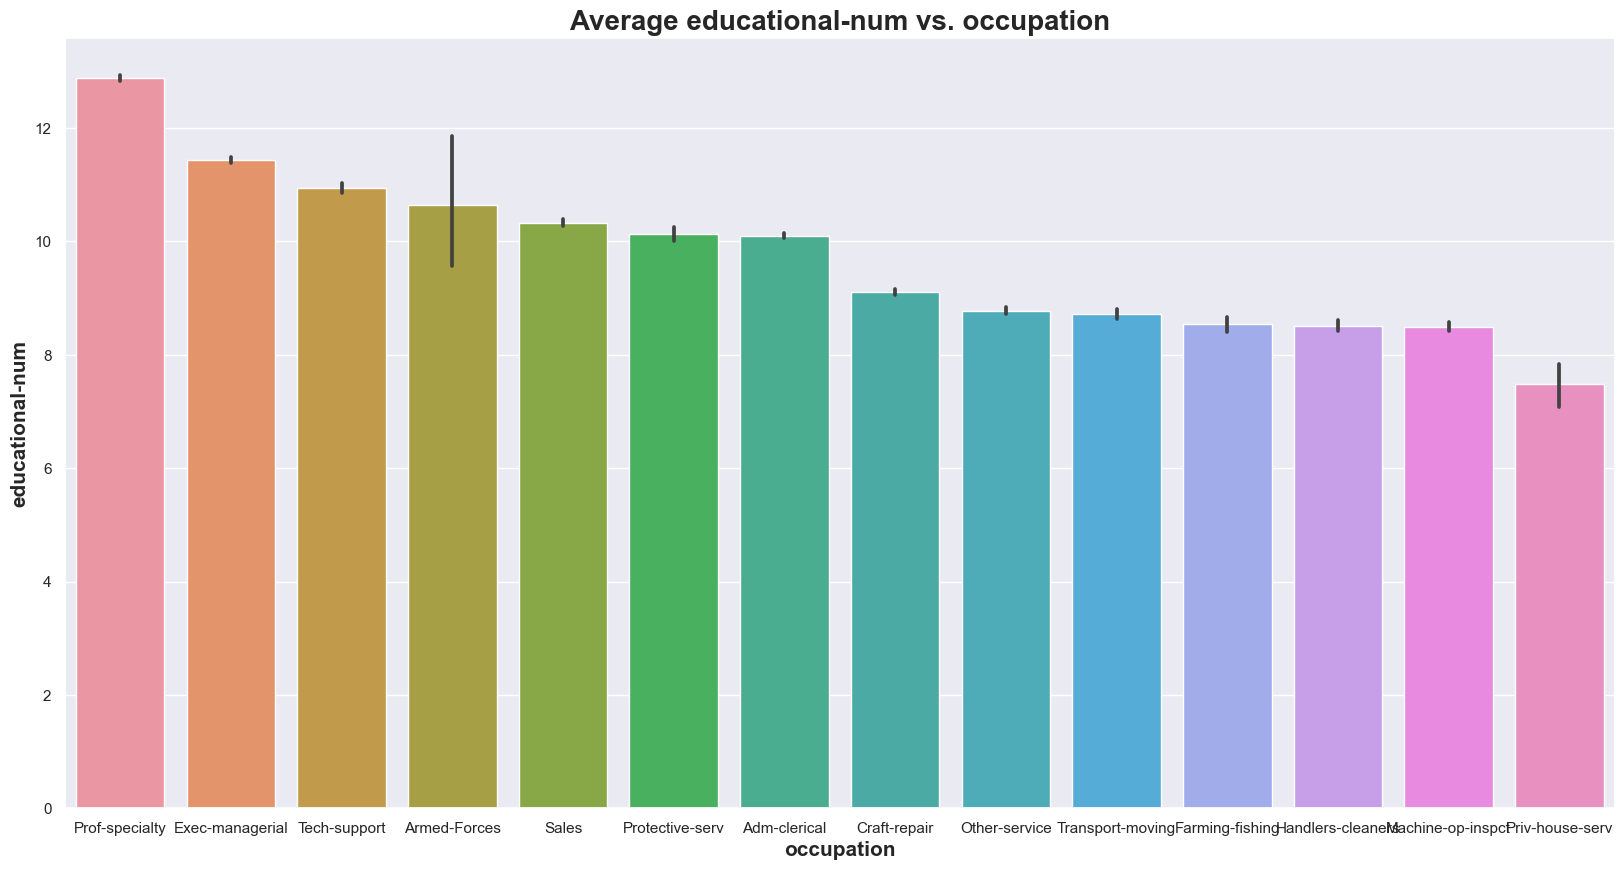

In [32]:
groupby_plot('occupation','educational-num')

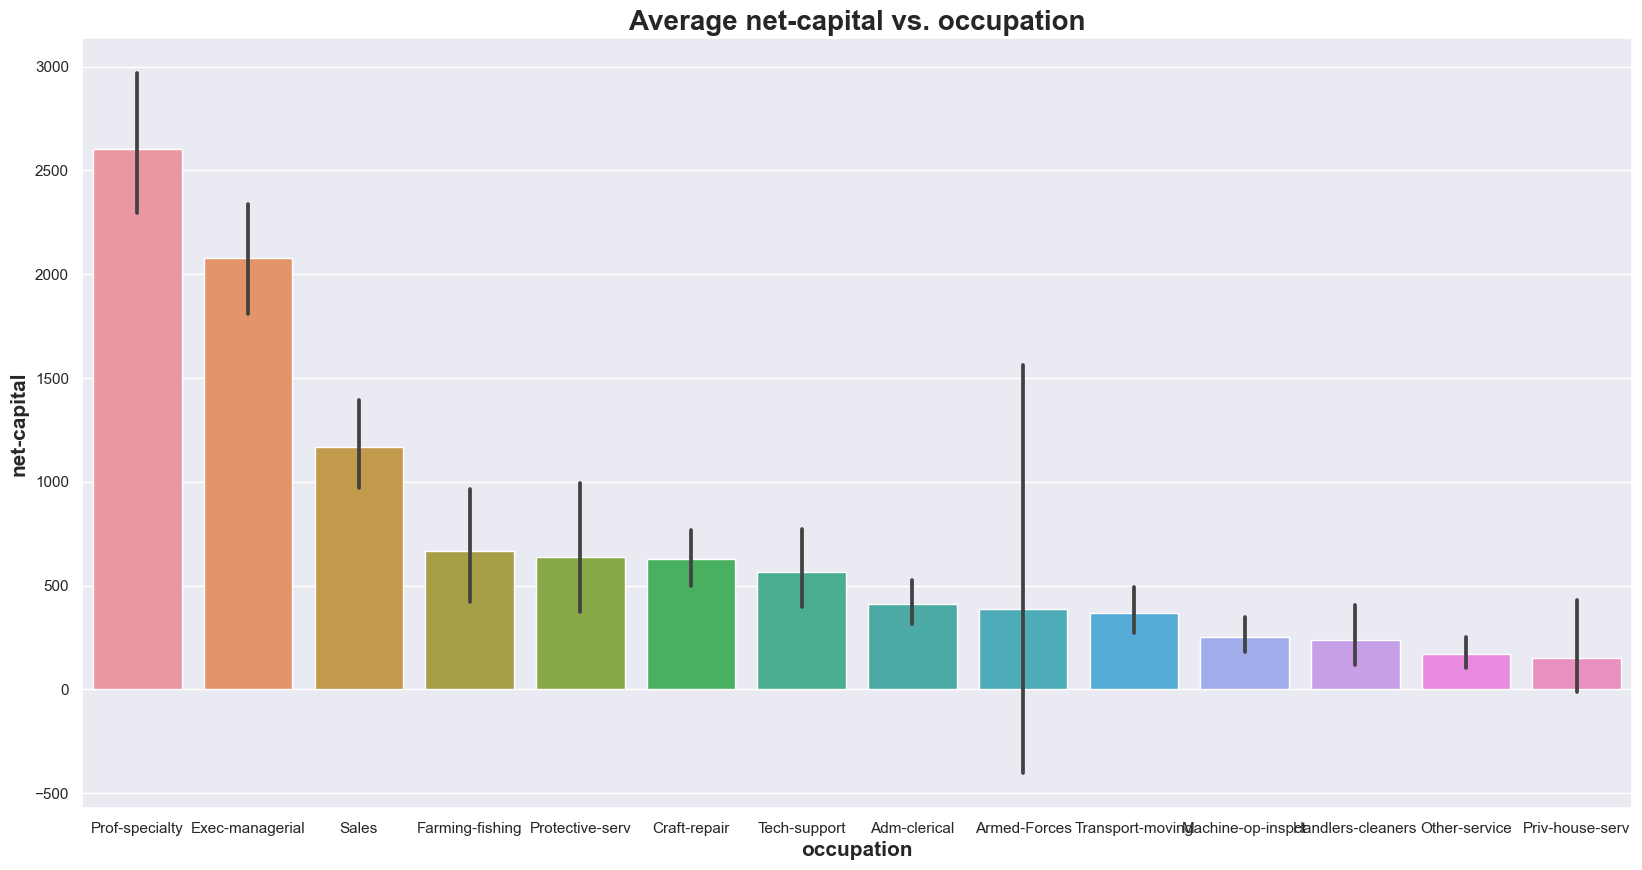

In [33]:
groupby_plot('occupation','net-capital')

# Part 4
**Modeling**

- Ensure that you complete the appropriate pre-processing steps.
- Fit and evaluate multiple types of models on your data.
    - Evaluate each model with multiple appropriate metrics on BOTH the train and test data.
    - Use GridSearchCV to tune some of the hyperparameters of each model.
    - Display the metrics of your best tuned version of each model type.
- Try feature engineering techniques or PCA to engineer your dataset to see how this impacts your modeling results. 
    - We encourage you to try multiple techniques depending on your data!
- Choose your "production" model and justify this decision using the metrics most important to your business problem.
- Go back through your code and ensure that you have provided clear comments (remember this is for your portfolio!).

**Readme**

- Create a README.md file in your GitHub repository.  This README should include:
    - Your business problem and stakeholders
    - The source of your data
    - A description of your data
    - 2 analytical insights from your data analysis.  
        - You can use the 2 plots from Project 2, part 3 for this!
        - They should include visualizations AND written interpretations
    - The metrics for your best model
    - A description of how well your model would solve your business problem
    - A summary with at least 2 recommendations for your stakeholders, based on your model performance AND analytical findings.

In [34]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45201 entries, 0 to 48841
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              45201 non-null  int64 
 1   IsGov            45201 non-null  int32 
 2   educational-num  45201 non-null  int64 
 3   marital-status   45201 non-null  object
 4   occupation       45201 non-null  object
 5   relationship     45201 non-null  object
 6   race             45201 non-null  object
 7   gender           45201 non-null  object
 8   hours-per-week   45201 non-null  int64 
 9   native-country   45201 non-null  object
 10  net-capital      45201 non-null  int64 
dtypes: int32(1), int64(4), object(6)
memory usage: 4.0+ MB


## Preprocessing

In [116]:
num_selector = make_column_selector(dtype_include = 'number')
cat_selector = make_column_selector(dtype_include = 'object')

scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
pca95 = PCA(0.95)

num_tuple = (scaler, num_selector)
cat_tuple = (ohe, cat_selector)

cols_transformer = make_column_transformer(num_tuple,cat_tuple, remainder = 'drop')

## Modeling

In [117]:
## Create a function to display the classification metrics of a model
def classification_metrics(model, X_test=X_test, y_test=y_test, label='Test Data', 
                             figsize=(15,5), normalize='true',
                             cmap='Greens', thresh=.5): 
                             
    fig, axes = plt.subplots(1,2, figsize=figsize)

    ## Get the predictions
    y_proba = model.predict_proba(X_test)
    y_pred = [1 if x[1] > thresh else 0 for x in y_proba]
    
    ## Print classification report for the test data (and make it pretty!)
    print('---'*20)
    print(f"[i] CLASSIFICATION REPORT FOR: {label}")
    print('---'*20)

    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test,y_pred, 
                normalize=normalize, cmap=cmap,              
                ax=axes[0])    
    
    RocCurveDisplay.from_estimator(model, X_test, y_test,
                                   ax=axes[1])
    plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
    plt.title(f'ROC AUC for {label}')
    plt.legend(); 
    plt.show()

### Random Forest

#### Base

In [44]:
model = RandomForestClassifier(random_state=42)
model_pipe = make_pipeline(cols_transformer,model)

In [45]:
%%time
model_pipe.fit(X_train,y_train)

C:\Users\mmenj\anaconda3\envs\dojo-env\lib\site-packages\sklearn\pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


CPU times: total: 3.89 s
Wall time: 3.98 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D09A00D640>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D098AFFD90>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [46]:
est_depths = [estimator.get_depth() for estimator in model_pipe.named_steps['randomforestclassifier'].estimators_]
print(f'The max depth of base Random Forest Classifier is {max(est_depths)}')

n_estimators = model_pipe.named_steps['randomforestclassifier'].n_estimators

print("Number of Estimators: ", n_estimators)

min_depth = np.min(est_depths)
mean_depth = np.mean(est_depths)
median_depth = np.median(est_depths)
mode_depth = np.argmax(np.bincount(est_depths))

print("Mean Depth: ", mean_depth)
print("Median Depth: ", median_depth)
print("Mode Depth: ", mode_depth)
print("Min Depth: ", min_depth)


The max depth of base Random Forest Classifier is 64
Number of Estimators:  100
Mean Depth:  52.87
Median Depth:  53.0
Mode Depth:  54
Min Depth:  39


In [47]:
%%time
preds = model_pipe.predict(X_test)

CPU times: total: 297 ms
Wall time: 362 ms


In [48]:
print('Training accuracy:', model_pipe.score(X_train, y_train))
print('Testing accuracy:', model_pipe.score(X_test, y_test))

Training accuracy: 0.9670417294232303
Testing accuracy: 0.8348688873139617


------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      8481
           1       0.70      0.60      0.64      2807

    accuracy                           0.83     11288
   macro avg       0.78      0.76      0.77     11288
weighted avg       0.83      0.83      0.83     11288



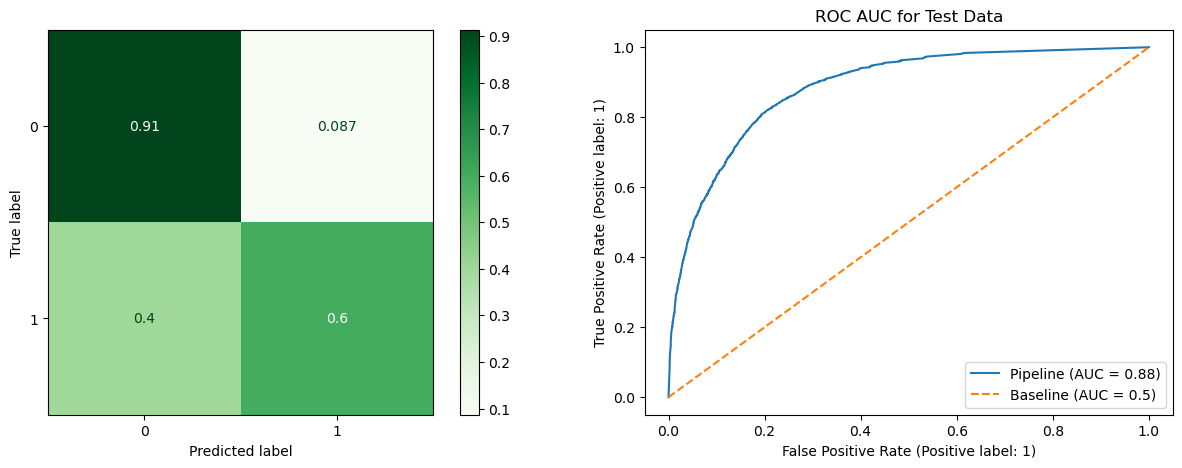

In [49]:
classification_metrics(model_pipe)

In [50]:
model_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001D09A00D640>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001D098AFFD90>)])),
  ('randomforestclassifier', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D09A00D640>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',


#### Base GS

In [67]:
param_grid = {
    'randomforestclassifier__max_depth': list(range(min_depth,max(est_depths)+1)),
}

In [68]:
model_pipe_gs = GridSearchCV(model_pipe, param_grid)

In [69]:
%%time
model_pipe_gs.fit(X_train,y_train[target].values.ravel())
print(model_pipe_gs.best_params_)

{'randomforestclassifier__max_depth': 47}
CPU times: total: 6min 51s
Wall time: 6min 55s


In [70]:
print('Training accuracy:', model_pipe_gs.score(X_train, y_train))
print('Testing accuracy:', model_pipe_gs.score(X_test, y_test))

Training accuracy: 0.9670417294232303
Testing accuracy: 0.835223245924876


------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      8481
           1       0.70      0.60      0.64      2807

    accuracy                           0.84     11288
   macro avg       0.78      0.76      0.77     11288
weighted avg       0.83      0.84      0.83     11288



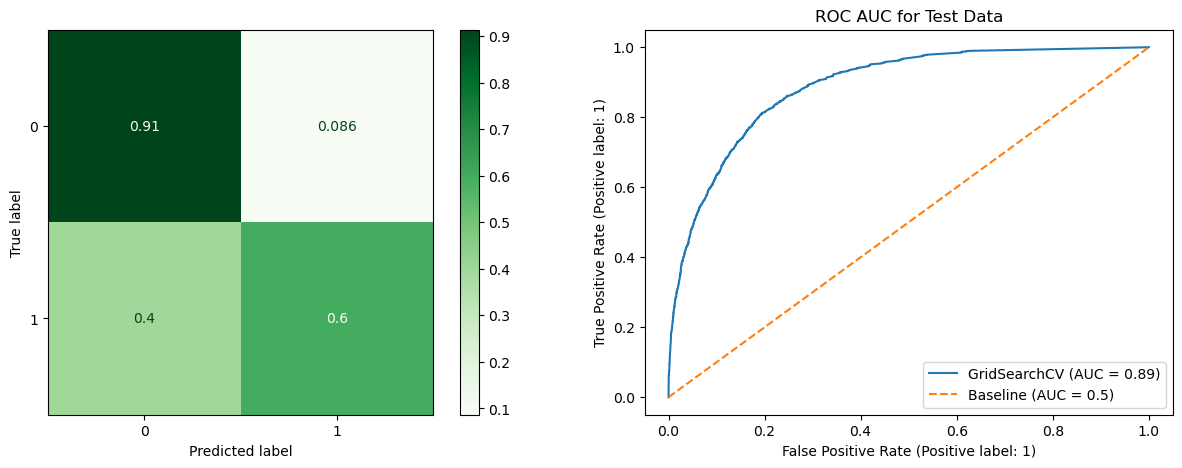

In [71]:
classification_metrics(model_pipe_gs)

#### Base GS 2

In [72]:
param_grid2 = {
    'randomforestclassifier__max_depth': list(range(min_depth,max(est_depths)+1)),
     'randomforestclassifier__n_estimators': [100, 150, 200, 250]
 }

In [78]:
model_pipe_gs2 = GridSearchCV(model_pipe, param_grid2, verbose=2)

In [79]:
%%time
model_pipe_gs2.fit(X_train,y_train[target].values.ravel())
print(model_pipe_gs2.best_params_)

Fitting 5 folds for each of 104 candidates, totalling 520 fits
[CV] END randomforestclassifier__max_depth=39, randomforestclassifier__n_estimators=100; total time=   3.3s
[CV] END randomforestclassifier__max_depth=39, randomforestclassifier__n_estimators=100; total time=   3.1s
[CV] END randomforestclassifier__max_depth=39, randomforestclassifier__n_estimators=100; total time=   3.0s
[CV] END randomforestclassifier__max_depth=39, randomforestclassifier__n_estimators=100; total time=   3.0s
[CV] END randomforestclassifier__max_depth=39, randomforestclassifier__n_estimators=100; total time=   3.0s
[CV] END randomforestclassifier__max_depth=39, randomforestclassifier__n_estimators=150; total time=   4.7s
[CV] END randomforestclassifier__max_depth=39, randomforestclassifier__n_estimators=150; total time=   4.5s
[CV] END randomforestclassifier__max_depth=39, randomforestclassifier__n_estimators=150; total time=   4.5s
[CV] END randomforestclassifier__max_depth=39, randomforestclassifier__n_

[CV] END randomforestclassifier__max_depth=42, randomforestclassifier__n_estimators=250; total time=   7.8s
[CV] END randomforestclassifier__max_depth=42, randomforestclassifier__n_estimators=250; total time=   7.7s
[CV] END randomforestclassifier__max_depth=42, randomforestclassifier__n_estimators=250; total time=   7.8s
[CV] END randomforestclassifier__max_depth=42, randomforestclassifier__n_estimators=250; total time=   7.8s
[CV] END randomforestclassifier__max_depth=43, randomforestclassifier__n_estimators=100; total time=   3.2s
[CV] END randomforestclassifier__max_depth=43, randomforestclassifier__n_estimators=100; total time=   3.1s
[CV] END randomforestclassifier__max_depth=43, randomforestclassifier__n_estimators=100; total time=   3.1s
[CV] END randomforestclassifier__max_depth=43, randomforestclassifier__n_estimators=100; total time=   3.1s
[CV] END randomforestclassifier__max_depth=43, randomforestclassifier__n_estimators=100; total time=   3.1s
[CV] END randomforestclassif

[CV] END randomforestclassifier__max_depth=46, randomforestclassifier__n_estimators=200; total time=   6.1s
[CV] END randomforestclassifier__max_depth=46, randomforestclassifier__n_estimators=200; total time=   6.2s
[CV] END randomforestclassifier__max_depth=46, randomforestclassifier__n_estimators=200; total time=   6.1s
[CV] END randomforestclassifier__max_depth=46, randomforestclassifier__n_estimators=250; total time=   8.0s
[CV] END randomforestclassifier__max_depth=46, randomforestclassifier__n_estimators=250; total time=   7.7s
[CV] END randomforestclassifier__max_depth=46, randomforestclassifier__n_estimators=250; total time=   7.8s
[CV] END randomforestclassifier__max_depth=46, randomforestclassifier__n_estimators=250; total time=   7.8s
[CV] END randomforestclassifier__max_depth=46, randomforestclassifier__n_estimators=250; total time=   7.8s
[CV] END randomforestclassifier__max_depth=47, randomforestclassifier__n_estimators=100; total time=   3.3s
[CV] END randomforestclassif

[CV] END randomforestclassifier__max_depth=50, randomforestclassifier__n_estimators=150; total time=   5.6s
[CV] END randomforestclassifier__max_depth=50, randomforestclassifier__n_estimators=150; total time=   5.5s
[CV] END randomforestclassifier__max_depth=50, randomforestclassifier__n_estimators=200; total time=   7.1s
[CV] END randomforestclassifier__max_depth=50, randomforestclassifier__n_estimators=200; total time=   6.3s
[CV] END randomforestclassifier__max_depth=50, randomforestclassifier__n_estimators=200; total time=   6.3s
[CV] END randomforestclassifier__max_depth=50, randomforestclassifier__n_estimators=200; total time=   6.7s
[CV] END randomforestclassifier__max_depth=50, randomforestclassifier__n_estimators=200; total time=   6.2s
[CV] END randomforestclassifier__max_depth=50, randomforestclassifier__n_estimators=250; total time=   7.9s
[CV] END randomforestclassifier__max_depth=50, randomforestclassifier__n_estimators=250; total time=   7.9s
[CV] END randomforestclassif

[CV] END randomforestclassifier__max_depth=54, randomforestclassifier__n_estimators=100; total time=   3.1s
[CV] END randomforestclassifier__max_depth=54, randomforestclassifier__n_estimators=150; total time=   4.7s
[CV] END randomforestclassifier__max_depth=54, randomforestclassifier__n_estimators=150; total time=   4.6s
[CV] END randomforestclassifier__max_depth=54, randomforestclassifier__n_estimators=150; total time=   4.6s
[CV] END randomforestclassifier__max_depth=54, randomforestclassifier__n_estimators=150; total time=   4.7s
[CV] END randomforestclassifier__max_depth=54, randomforestclassifier__n_estimators=150; total time=   4.7s
[CV] END randomforestclassifier__max_depth=54, randomforestclassifier__n_estimators=200; total time=   6.2s
[CV] END randomforestclassifier__max_depth=54, randomforestclassifier__n_estimators=200; total time=   6.1s
[CV] END randomforestclassifier__max_depth=54, randomforestclassifier__n_estimators=200; total time=   6.1s
[CV] END randomforestclassif

[CV] END randomforestclassifier__max_depth=58, randomforestclassifier__n_estimators=100; total time=   3.1s
[CV] END randomforestclassifier__max_depth=58, randomforestclassifier__n_estimators=100; total time=   3.1s
[CV] END randomforestclassifier__max_depth=58, randomforestclassifier__n_estimators=100; total time=   3.0s
[CV] END randomforestclassifier__max_depth=58, randomforestclassifier__n_estimators=100; total time=   3.3s
[CV] END randomforestclassifier__max_depth=58, randomforestclassifier__n_estimators=100; total time=   3.1s
[CV] END randomforestclassifier__max_depth=58, randomforestclassifier__n_estimators=150; total time=   4.7s
[CV] END randomforestclassifier__max_depth=58, randomforestclassifier__n_estimators=150; total time=   4.6s
[CV] END randomforestclassifier__max_depth=58, randomforestclassifier__n_estimators=150; total time=   4.5s
[CV] END randomforestclassifier__max_depth=58, randomforestclassifier__n_estimators=150; total time=   4.6s
[CV] END randomforestclassif

[CV] END randomforestclassifier__max_depth=61, randomforestclassifier__n_estimators=250; total time=   7.6s
[CV] END randomforestclassifier__max_depth=61, randomforestclassifier__n_estimators=250; total time=   7.6s
[CV] END randomforestclassifier__max_depth=61, randomforestclassifier__n_estimators=250; total time=   7.7s
[CV] END randomforestclassifier__max_depth=61, randomforestclassifier__n_estimators=250; total time=   7.7s
[CV] END randomforestclassifier__max_depth=62, randomforestclassifier__n_estimators=100; total time=   3.1s
[CV] END randomforestclassifier__max_depth=62, randomforestclassifier__n_estimators=100; total time=   3.1s
[CV] END randomforestclassifier__max_depth=62, randomforestclassifier__n_estimators=100; total time=   3.1s
[CV] END randomforestclassifier__max_depth=62, randomforestclassifier__n_estimators=100; total time=   3.1s
[CV] END randomforestclassifier__max_depth=62, randomforestclassifier__n_estimators=100; total time=   3.0s
[CV] END randomforestclassif

Training accuracy: 0.9668645344201293
Testing accuracy: 0.8372608079376329
------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      8481
           1       0.70      0.59      0.65      2807

    accuracy                           0.84     11288
   macro avg       0.79      0.76      0.77     11288
weighted avg       0.83      0.84      0.83     11288



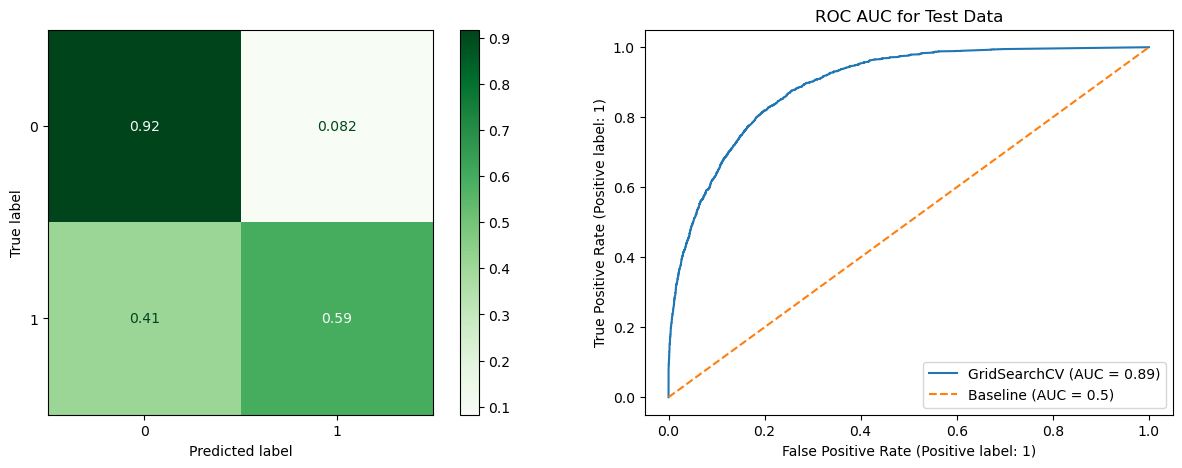

In [80]:
print('Training accuracy:', model_pipe_gs2.score(X_train, y_train))
print('Testing accuracy:', model_pipe_gs2.score(X_test, y_test))
classification_metrics(model_pipe_gs2)

#### Base PCA 95%

In [88]:
model_pipe_pca = make_pipeline(cols_transformer,pca95,model)

In [89]:
%%time
model_pipe_pca.fit(X_train,y_train[target].values.ravel())

CPU times: total: 14.1 s
Wall time: 13.5 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D09A00D640>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D098AFFD90>)])),
                ('pca', PCA(n_components=0.95)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

Training accuracy: 0.967071261923747
Testing accuracy: 0.8233522324592487
------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      8481
           1       0.67      0.58      0.62      2807

    accuracy                           0.82     11288
   macro avg       0.77      0.74      0.75     11288
weighted avg       0.82      0.82      0.82     11288



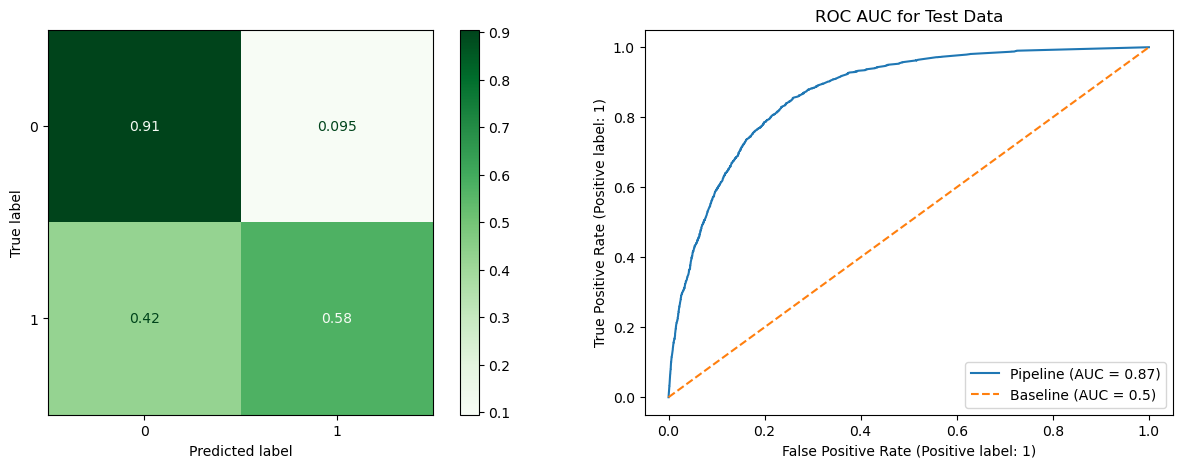

In [90]:
print('Training accuracy:', model_pipe_pca.score(X_train, y_train))
print('Testing accuracy:',  model_pipe_pca.score(X_test, y_test))
classification_metrics(model_pipe_pca)

#### PCA GS

In [91]:
est_depths = [estimator.get_depth() for estimator in model_pipe_pca.named_steps['randomforestclassifier'].estimators_]
print(f'The max depth of pca Random Forest Classifier is {max(est_depths)}')

n_estimators = model_pipe_pca.named_steps['randomforestclassifier'].n_estimators

print("Number of Estimators: ", n_estimators)

min_depth = np.min(est_depths)
mean_depth = np.mean(est_depths)
median_depth = np.median(est_depths)
mode_depth = np.argmax(np.bincount(est_depths))

print("Mean Depth: ", mean_depth)
print("Median Depth: ", median_depth)
print("Mode Depth: ", mode_depth)
print("Min Depth: ", min_depth)


The max depth of pca Random Forest Classifier is 46
Number of Estimators:  100
Mean Depth:  36.82
Median Depth:  37.0
Mode Depth:  38
Min Depth:  30


In [92]:
param_grid = {
    'randomforestclassifier__max_depth': list(range(min_depth,max(est_depths)+1)),
}

In [93]:
model_pipe_pca_gs = GridSearchCV(model_pipe_pca, param_grid, verbose=2)

In [94]:
%%time
model_pipe_pca_gs.fit(X_train,y_train[target].values.ravel())
print(model_pipe_pca_gs.best_params_)

Fitting 5 folds for each of 17 candidates, totalling 85 fits
[CV] END ...............randomforestclassifier__max_depth=30; total time=  10.4s
[CV] END ...............randomforestclassifier__max_depth=30; total time=  10.5s
[CV] END ...............randomforestclassifier__max_depth=30; total time=  10.6s
[CV] END ...............randomforestclassifier__max_depth=30; total time=  10.9s
[CV] END ...............randomforestclassifier__max_depth=30; total time=  10.7s
[CV] END ...............randomforestclassifier__max_depth=31; total time=  10.3s
[CV] END ...............randomforestclassifier__max_depth=31; total time=  10.3s
[CV] END ...............randomforestclassifier__max_depth=31; total time=  10.3s
[CV] END ...............randomforestclassifier__max_depth=31; total time=  10.5s
[CV] END ...............randomforestclassifier__max_depth=31; total time=  10.4s
[CV] END ...............randomforestclassifier__max_depth=32; total time=  10.2s
[CV] END ...............randomforestclassifier__

Training accuracy: 0.967071261923747
Testing accuracy: 0.8234408221119773
------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      8481
           1       0.67      0.57      0.62      2807

    accuracy                           0.82     11288
   macro avg       0.77      0.74      0.75     11288
weighted avg       0.82      0.82      0.82     11288



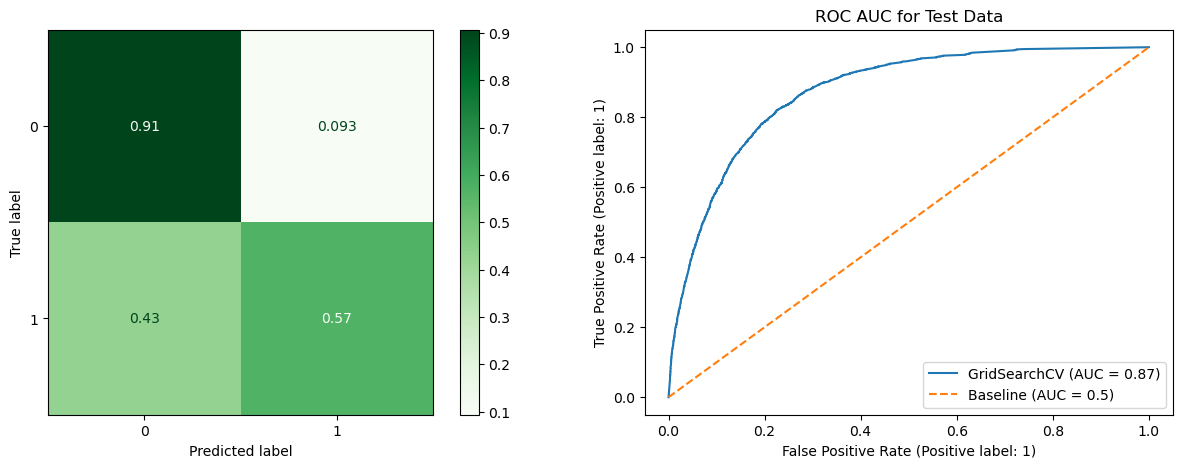

In [95]:
print('Training accuracy:', model_pipe_pca_gs.score(X_train, y_train))
print('Testing accuracy:',  model_pipe_pca_gs.score(X_test, y_test))
classification_metrics(model_pipe_pca_gs)

#### PCA GS 2

In [98]:
param_grid2 = {
    'randomforestclassifier__max_depth': list(range(min_depth,max(est_depths)+1)),
     'randomforestclassifier__n_estimators': [100, 150, 200, 250]
 }

In [99]:
model_pipe_pca_gs2 = GridSearchCV(model_pipe_pca, param_grid2, verbose=2)

In [100]:
%%time
model_pipe_pca_gs2.fit(X_train, y_train[target].values.ravel())
print(model_pipe_pca_gs2.best_params_)

Fitting 5 folds for each of 68 candidates, totalling 340 fits
[CV] END randomforestclassifier__max_depth=30, randomforestclassifier__n_estimators=100; total time=  10.5s
[CV] END randomforestclassifier__max_depth=30, randomforestclassifier__n_estimators=100; total time=  10.4s
[CV] END randomforestclassifier__max_depth=30, randomforestclassifier__n_estimators=100; total time=  11.0s
[CV] END randomforestclassifier__max_depth=30, randomforestclassifier__n_estimators=100; total time=  10.7s
[CV] END randomforestclassifier__max_depth=30, randomforestclassifier__n_estimators=100; total time=  10.3s
[CV] END randomforestclassifier__max_depth=30, randomforestclassifier__n_estimators=150; total time=  15.4s
[CV] END randomforestclassifier__max_depth=30, randomforestclassifier__n_estimators=150; total time=  15.5s
[CV] END randomforestclassifier__max_depth=30, randomforestclassifier__n_estimators=150; total time=  15.4s
[CV] END randomforestclassifier__max_depth=30, randomforestclassifier__n_e

[CV] END randomforestclassifier__max_depth=33, randomforestclassifier__n_estimators=250; total time=  25.9s
[CV] END randomforestclassifier__max_depth=33, randomforestclassifier__n_estimators=250; total time=  25.8s
[CV] END randomforestclassifier__max_depth=33, randomforestclassifier__n_estimators=250; total time=  26.1s
[CV] END randomforestclassifier__max_depth=33, randomforestclassifier__n_estimators=250; total time=  25.6s
[CV] END randomforestclassifier__max_depth=34, randomforestclassifier__n_estimators=100; total time=  10.3s
[CV] END randomforestclassifier__max_depth=34, randomforestclassifier__n_estimators=100; total time=  10.4s
[CV] END randomforestclassifier__max_depth=34, randomforestclassifier__n_estimators=100; total time=  10.4s
[CV] END randomforestclassifier__max_depth=34, randomforestclassifier__n_estimators=100; total time=  10.4s
[CV] END randomforestclassifier__max_depth=34, randomforestclassifier__n_estimators=100; total time=  10.2s
[CV] END randomforestclassif

[CV] END randomforestclassifier__max_depth=37, randomforestclassifier__n_estimators=200; total time=  20.7s
[CV] END randomforestclassifier__max_depth=37, randomforestclassifier__n_estimators=200; total time=  20.9s
[CV] END randomforestclassifier__max_depth=37, randomforestclassifier__n_estimators=200; total time=  20.6s
[CV] END randomforestclassifier__max_depth=37, randomforestclassifier__n_estimators=250; total time=  25.6s
[CV] END randomforestclassifier__max_depth=37, randomforestclassifier__n_estimators=250; total time=  26.0s
[CV] END randomforestclassifier__max_depth=37, randomforestclassifier__n_estimators=250; total time=  25.7s
[CV] END randomforestclassifier__max_depth=37, randomforestclassifier__n_estimators=250; total time=  26.3s
[CV] END randomforestclassifier__max_depth=37, randomforestclassifier__n_estimators=250; total time=  25.7s
[CV] END randomforestclassifier__max_depth=38, randomforestclassifier__n_estimators=100; total time=  10.2s
[CV] END randomforestclassif

[CV] END randomforestclassifier__max_depth=41, randomforestclassifier__n_estimators=150; total time=  15.7s
[CV] END randomforestclassifier__max_depth=41, randomforestclassifier__n_estimators=150; total time=  15.5s
[CV] END randomforestclassifier__max_depth=41, randomforestclassifier__n_estimators=200; total time=  20.6s
[CV] END randomforestclassifier__max_depth=41, randomforestclassifier__n_estimators=200; total time=  20.9s
[CV] END randomforestclassifier__max_depth=41, randomforestclassifier__n_estimators=200; total time=  20.7s
[CV] END randomforestclassifier__max_depth=41, randomforestclassifier__n_estimators=200; total time=  20.9s
[CV] END randomforestclassifier__max_depth=41, randomforestclassifier__n_estimators=200; total time=  20.6s
[CV] END randomforestclassifier__max_depth=41, randomforestclassifier__n_estimators=250; total time=  25.8s
[CV] END randomforestclassifier__max_depth=41, randomforestclassifier__n_estimators=250; total time=  26.1s
[CV] END randomforestclassif

[CV] END randomforestclassifier__max_depth=45, randomforestclassifier__n_estimators=100; total time=  10.3s
[CV] END randomforestclassifier__max_depth=45, randomforestclassifier__n_estimators=150; total time=  15.3s
[CV] END randomforestclassifier__max_depth=45, randomforestclassifier__n_estimators=150; total time=  15.5s
[CV] END randomforestclassifier__max_depth=45, randomforestclassifier__n_estimators=150; total time=  15.5s
[CV] END randomforestclassifier__max_depth=45, randomforestclassifier__n_estimators=150; total time=  15.7s
[CV] END randomforestclassifier__max_depth=45, randomforestclassifier__n_estimators=150; total time=  15.4s
[CV] END randomforestclassifier__max_depth=45, randomforestclassifier__n_estimators=200; total time=  20.5s
[CV] END randomforestclassifier__max_depth=45, randomforestclassifier__n_estimators=200; total time=  20.9s
[CV] END randomforestclassifier__max_depth=45, randomforestclassifier__n_estimators=200; total time=  20.5s
[CV] END randomforestclassif

Training accuracy: 0.967071261923747
Testing accuracy: 0.8234408221119773
------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      8481
           1       0.67      0.57      0.62      2807

    accuracy                           0.82     11288
   macro avg       0.77      0.74      0.75     11288
weighted avg       0.82      0.82      0.82     11288



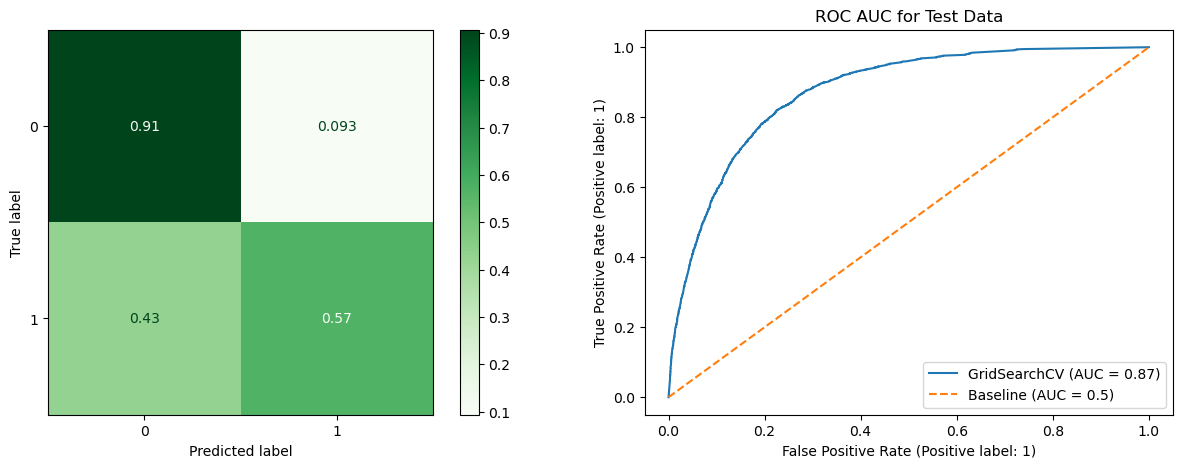

In [101]:
print('Training accuracy:', model_pipe_pca_gs2.score(X_train, y_train))
print('Testing accuracy:',  model_pipe_pca_gs2.score(X_test, y_test))
classification_metrics(model_pipe_pca_gs2)

### GBC

In [43]:
# Instantiate and fit gradient boosting classifier
model = GradientBoostingClassifier(random_state=42)
model_pipe = make_pipeline(cols_transformer,model)

In [45]:
model_pipe.fit(X_train, y_train[target].values.ravel())

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D2F5344610>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D2F5336A00>)])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      8560
           1       0.78      0.61      0.68      2741

    accuracy                           0.86     11301
   macro avg       0.83      0.78      0.80     11301
weighted avg       0.86      0.86      0.86     11301



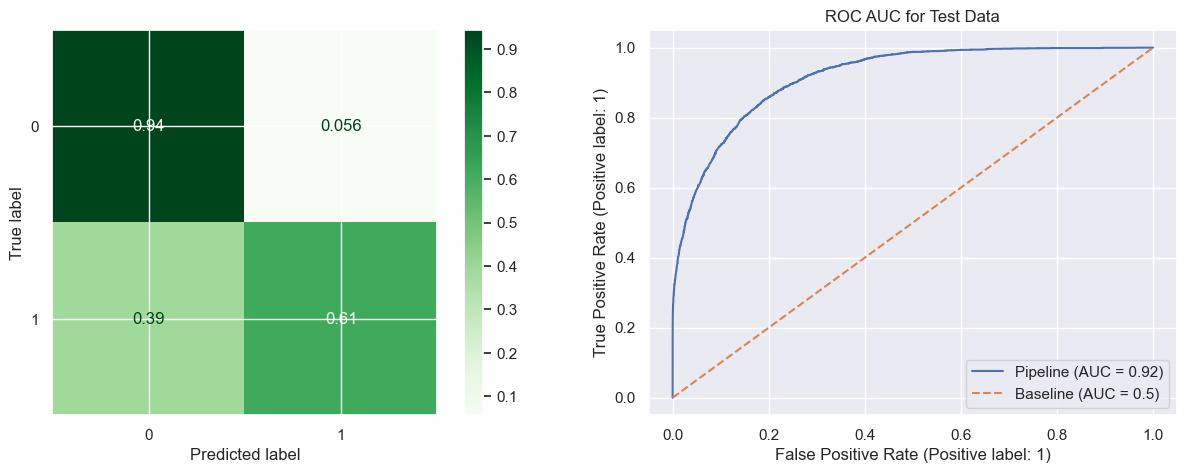

In [46]:
classification_metrics(model_pipe)

### LGBM

#### Base

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      8481
           1       0.77      0.64      0.70      2807

    accuracy                           0.86     11288
   macro avg       0.83      0.79      0.81     11288
weighted avg       0.86      0.86      0.86     11288



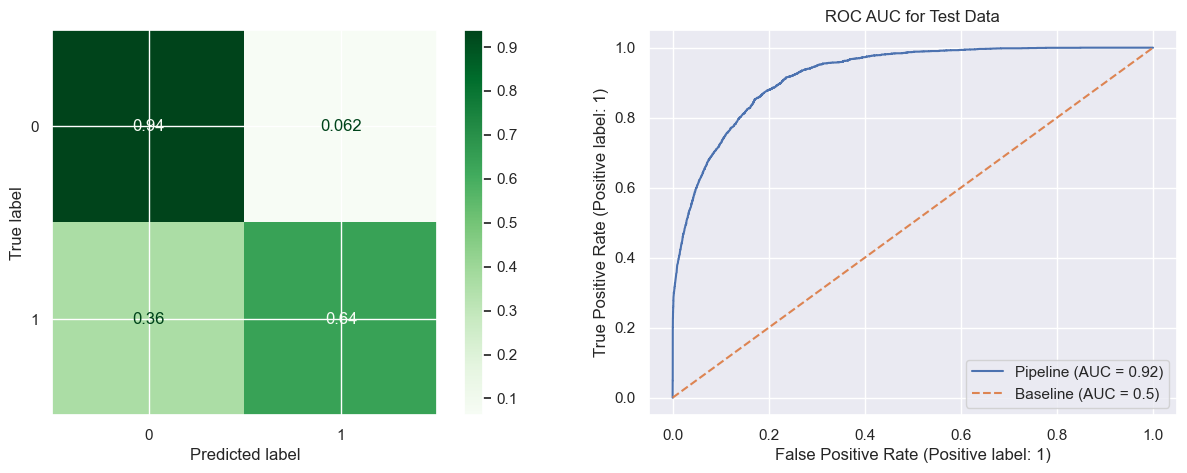

In [118]:
# Instantiate and fit gradient boosting classifier
model = LGBMClassifier(random_state=42)
model_pipe = make_pipeline(cols_transformer,model)
model_pipe.fit(X_train, y_train[target].values.ravel())
classification_metrics(model_pipe)

In [119]:
booster_model = model_pipe.named_steps['lgbmclassifier'].booster_

# Get the number of trees in the booster model
num_trees = booster_model.num_trees()

# Calculate the actual depth of the base model
base_model_depth = num_trees // model.n_estimators

print("Actual depth of the base model: ", base_model_depth)

Actual depth of the base model:  1


#### GS

In [148]:
param_grid = {
    'lgbmclassifier__learning_rate': [0.1, 0.05, 0.01],  # List of values for learning rate
    'lgbmclassifier__max_depth': list(range(1, 6)),  # List of values for max depth
    'lgbmclassifier__n_estimators': [100, 200, 300]  # List of values for n_estimators
}

In [150]:
# Instantiate and fit gradient boosting classifier
model = LGBMClassifier(random_state=42)
model_pipe = make_pipeline(cols_transformer,model)
model_pipe_gs = GridSearchCV(model_pipe, param_grid, verbose =2)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=1, lgbmclassifier__n_estimators=100; total time=   0.2s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=1, lgbmclassifier__n_estimators=100; total time=   0.2s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=1, lgbmclassifier__n_estimators=100; total time=   0.2s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=1, lgbmclassifier__n_estimators=100; total time=   0.2s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=1, lgbmclassifier__n_estimators=100; total time=   0.2s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=1, lgbmclassifier__n_estimators=200; total time=   0.2s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=1, lgbmclassifier__n_estimators=200; total time=   0.2s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifi

[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=200; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=200; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=200; total time=   0.4s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=200; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=200; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=300; total time=   0.6s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=300; total time=   0.6s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=300; total time=

[CV] END lgbmclassifier__learning_rate=0.05, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=300; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.05, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=300; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.05, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=300; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.05, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=300; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.05, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=300; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.05, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=100; total time=   0.3s
[CV] END lgbmclassifier__learning_rate=0.05, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=100; total time=   0.3s
[CV] END lgbmclassifier__learning_rate=0.05, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=100; tot

[CV] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=100; total time=   0.3s
[CV] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=100; total time=   0.3s
[CV] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=100; total time=   0.3s
[CV] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=100; total time=   0.3s
[CV] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=100; total time=   0.3s
[CV] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=200; total time=   0.4s
[CV] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=200; total time=   0.4s
[CV] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=200; tot

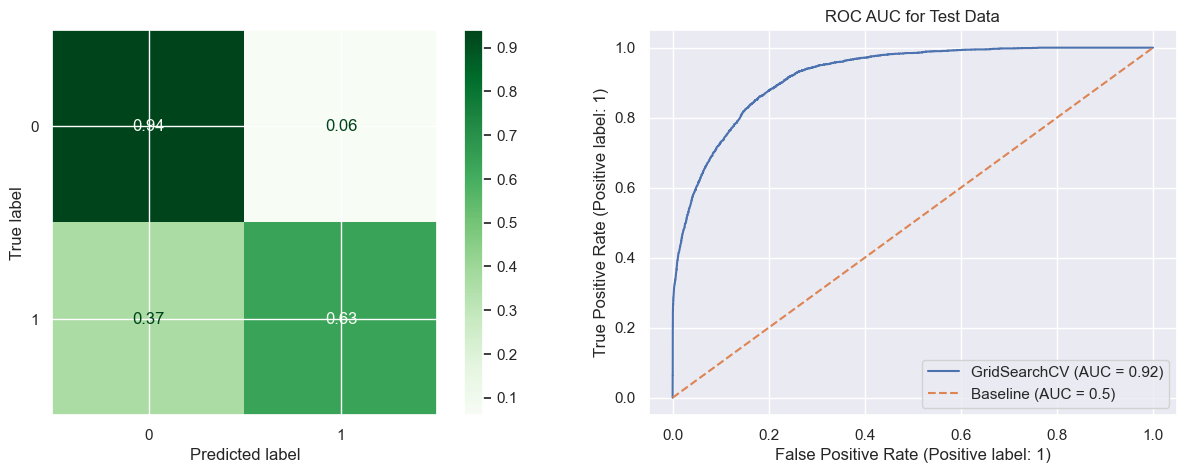

CPU times: total: 11min 7s
Wall time: 1min 43s


In [151]:
%%time
model_pipe_gs.fit(X_train, y_train[target].values.ravel())
model_pipe.get_params()
classification_metrics(model_pipe_gs)

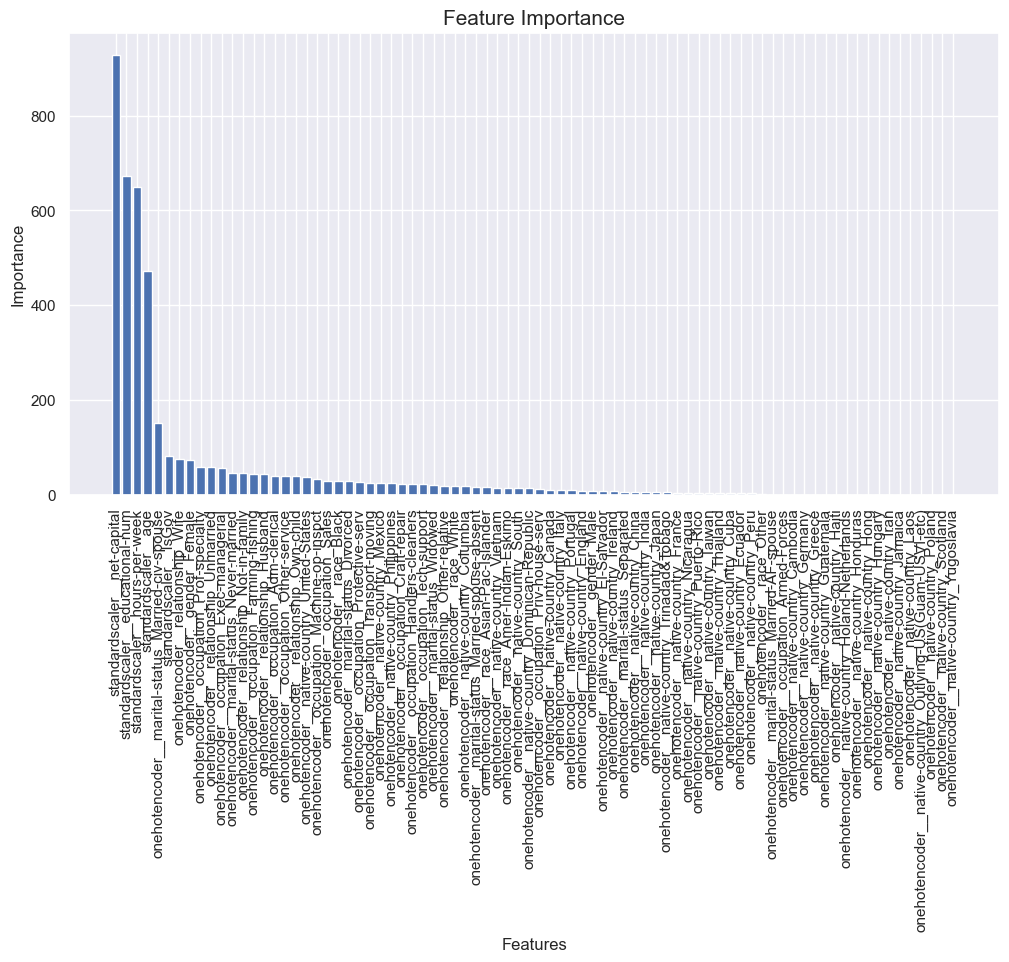

In [127]:
best_model = model_pipe_gs.best_estimator_

# Retrieve feature importances from the best model
feature_importance = best_model.named_steps['lgbmclassifier'].feature_importances_

# Get feature names from the columns in cols_transformer
feature_names = model_pipe.named_steps['columntransformer'].get_feature_names_out()

# Create a dictionary of feature names and their importance values
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort the feature importance dictionary by importance values
sorted_feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

# Convert the sorted feature importance dictionary to lists
sorted_feature_names = list(sorted_feature_importance_dict.keys())
sorted_feature_importance = list(sorted_feature_importance_dict.values())

# Create a bar plot of feature importance
plt.figure(figsize=(12, 6))
plt.bar(sorted_feature_names, sorted_feature_importance)
plt.title('Feature Importance', fontsize=15)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [128]:
# Calculate total feature importance value
total_importance = sum(sorted_feature_importance_dict.values())

# Create a combined feature importance dictionary
combined_feature_importance_dict = {}
for feature, importance in sorted_feature_importance_dict.items():
    importance_percent = (importance / total_importance) * 100
    combined_feature_importance_dict[feature] = importance_percent / 100

# Print combined feature importance dictionary
print("Combined Feature Importance:")
for feature, importance in combined_feature_importance_dict.items():
    print(f"'{feature}': {importance:.2f},")

Combined Feature Importance:
'standardscaler__net-capital': 0.22,
'standardscaler__educational-num': 0.16,
'standardscaler__hours-per-week': 0.15,
'standardscaler__age': 0.11,
'onehotencoder__marital-status_Married-civ-spouse': 0.04,
'standardscaler__IsGov': 0.02,
'onehotencoder__relationship_Wife': 0.02,
'onehotencoder__gender_Female': 0.02,
'onehotencoder__occupation_Prof-specialty': 0.01,
'onehotencoder__relationship_Unmarried': 0.01,
'onehotencoder__occupation_Exec-managerial': 0.01,
'onehotencoder__marital-status_Never-married': 0.01,
'onehotencoder__relationship_Not-in-family': 0.01,
'onehotencoder__occupation_Farming-fishing': 0.01,
'onehotencoder__relationship_Husband': 0.01,
'onehotencoder__occupation_Adm-clerical': 0.01,
'onehotencoder__occupation_Other-service': 0.01,
'onehotencoder__relationship_Own-child': 0.01,
'onehotencoder__native-country_United-States': 0.01,
'onehotencoder__occupation_Machine-op-inspct': 0.01,
'onehotencoder__occupation_Sales': 0.01,
'onehotencoder__

In [129]:
# Calculate total feature importance value
total_importance = sum(feature_importance_dict.values())

# Create a combined feature importance dictionary
combined_feature_importance_dict = {}
for feature, importance in sorted_feature_importance_dict.items():
    # Extract the original feature/column name from the columntransformer feature name
    original_feature_name = feature.split('__')[1]  # Assumes columntransformer separator is '__'
    prefix = original_feature_name.split('_')[0]  # Extract prefix from original feature name
    if prefix not in combined_feature_importance_dict:
        combined_feature_importance_dict[prefix] = 0
    combined_feature_importance_dict[prefix] += (importance / total_importance)

# Sort combined feature importance dictionary in descending order
sorted_combined_feature_importance_dict = dict(sorted(combined_feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

# Print combined feature importance dictionary in descending order
print("Combined Feature Importance (Descending Order):")
for feature, importance in sorted_combined_feature_importance_dict.items():
    print(f"'{feature}': {importance:.2f},")

Combined Feature Importance (Descending Order):
'net-capital': 0.22,
'educational-num': 0.16,
'hours-per-week': 0.15,
'age': 0.11,
'occupation': 0.10,
'relationship': 0.07,
'marital-status': 0.06,
'native-country': 0.06,
'IsGov': 0.02,
'race': 0.02,
'gender': 0.02,


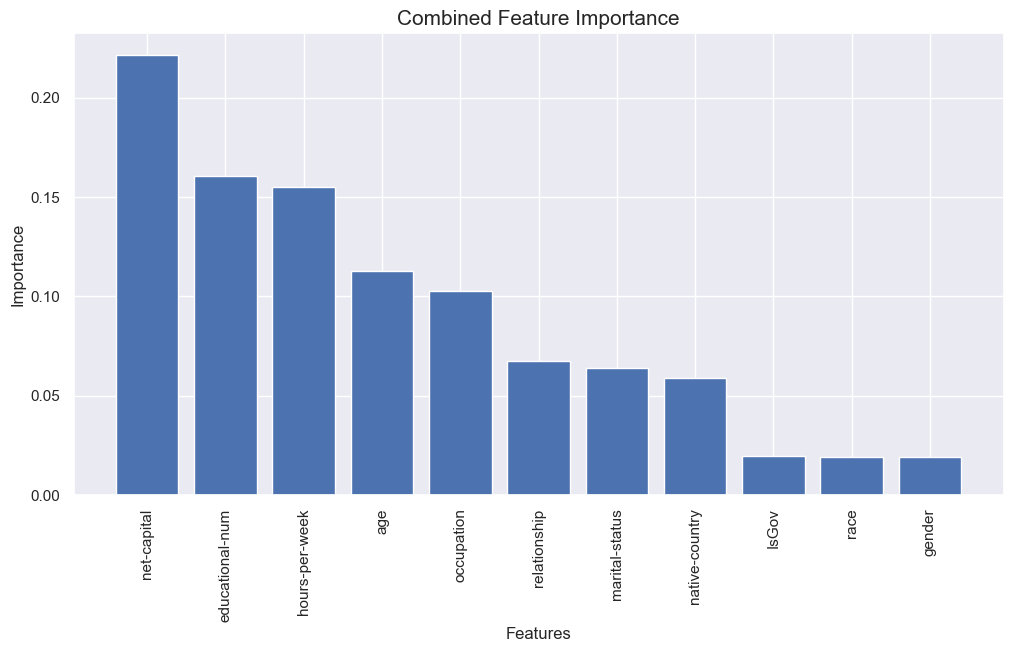

In [130]:
sorted_combined_feature_names = list(sorted_combined_feature_importance_dict.keys())
sorted_combined_feature_importance = list(sorted_combined_feature_importance_dict.values())

plt.figure(figsize=(12, 6))
plt.bar(sorted_combined_feature_names, sorted_combined_feature_importance)
plt.title('Combined Feature Importance', fontsize=15)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=90)
plt.show()

#### Weighted

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      8481
           1       0.61      0.86      0.71      2807

    accuracy                           0.83     11288
   macro avg       0.78      0.84      0.80     11288
weighted avg       0.86      0.83      0.84     11288



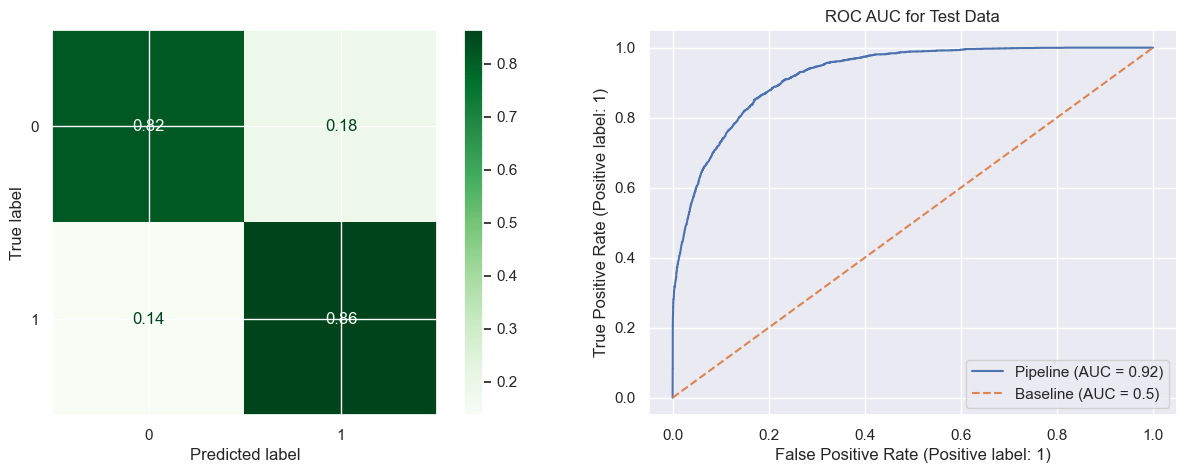

In [132]:
# Instantiate and fit gradient boosting classifier
model = LGBMClassifier(random_state=42, class_weight='balanced')
model_pipe = make_pipeline(cols_transformer,model)
model_pipe.fit(X_train, y_train[target].values.ravel())
classification_metrics(model_pipe)

In [133]:
model_pipe_gs = GridSearchCV(model_pipe, param_grid, verbose =2)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=1, lgbmclassifier__n_estimators=100; total time=   0.1s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=1, lgbmclassifier__n_estimators=100; total time=   0.2s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=1, lgbmclassifier__n_estimators=100; total time=   0.2s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=1, lgbmclassifier__n_estimators=100; total time=   0.2s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=1, lgbmclassifier__n_estimators=100; total time=   0.2s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=1, lgbmclassifier__n_estimators=200; total time=   0.2s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=1, lgbmclassifier__n_estimators=200; total time=   0.2s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifi

[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=200; total time=   0.4s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=200; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=200; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=200; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=200; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=300; total time=   0.7s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=300; total time=   0.6s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=300; total time=

[CV] END lgbmclassifier__learning_rate=0.05, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=300; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.05, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=300; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.05, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=300; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.05, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=300; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.05, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=300; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.05, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=100; total time=   0.3s
[CV] END lgbmclassifier__learning_rate=0.05, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=100; total time=   0.3s
[CV] END lgbmclassifier__learning_rate=0.05, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=100; tot

[CV] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=100; total time=   0.3s
[CV] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=100; total time=   0.3s
[CV] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=100; total time=   0.3s
[CV] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=100; total time=   0.3s
[CV] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=100; total time=   0.3s
[CV] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=200; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=200; total time=   0.5s
[CV] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=200; tot

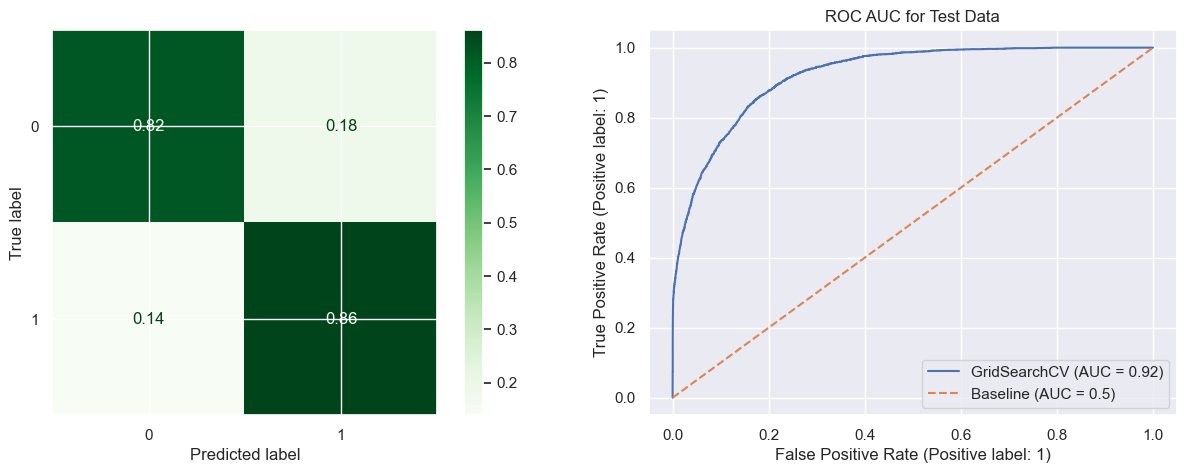

CPU times: total: 11min 27s
Wall time: 1min 48s


In [134]:
%%time
model_pipe_gs.fit(X_train, y_train[target].values.ravel())
classification_metrics(model_pipe_gs)

#### SMOTE

In [66]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sampler_pipeline

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      8560
           1       0.65      0.79      0.71      2741

    accuracy                           0.84     11301
   macro avg       0.79      0.82      0.80     11301
weighted avg       0.86      0.84      0.85     11301



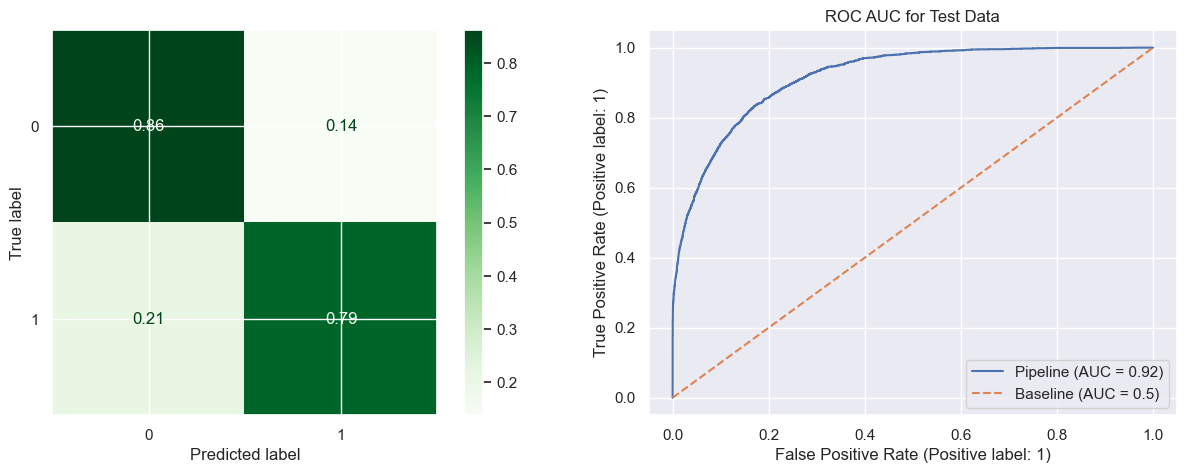

In [68]:
smote = SMOTE()
model = LGBMClassifier(random_state=42)
model_pipe = make_sampler_pipeline(cols_transformer,smote,model)
model_pipe.fit(X_train, y_train[target].values.ravel())
classification_metrics(model_pipe)

### XGBoost

In [52]:
from xgboost import XGBClassifier

C:\Users\mmenj\anaconda3\envs\dojo-env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


C:\Users\mmenj\anaconda3\envs\dojo-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:11:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      8560
           1       0.77      0.65      0.70      2741

    accuracy                           0.87     11301
   macro avg       0.83      0.79      0.81     11301
weighted avg       0.86      0.87      0.86     11301



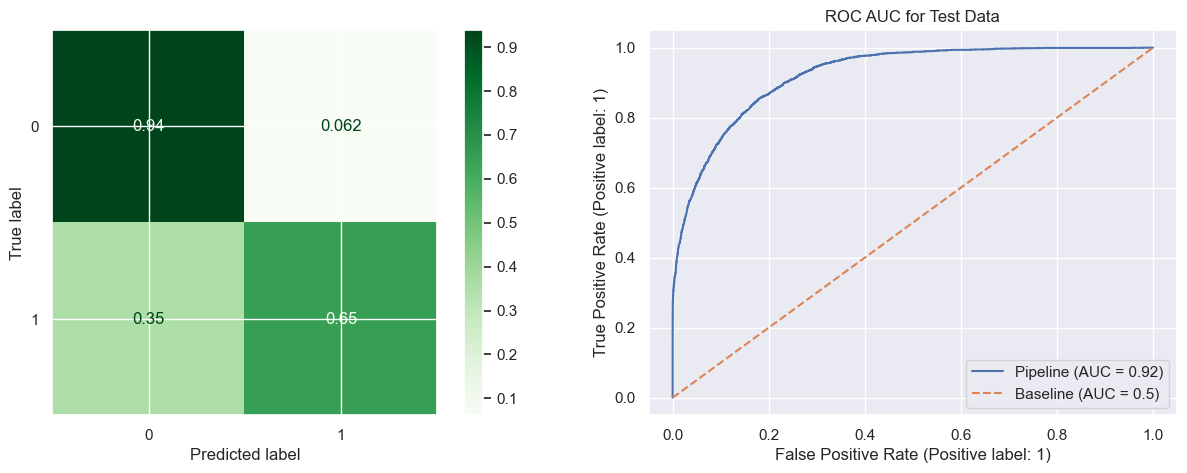

In [53]:
# Instantiate and fit gradient boosting classifier
model = XGBClassifier(random_state=42)
model_pipe = make_pipeline(cols_transformer,model)
model_pipe.fit(X_train, y_train[target].values.ravel())
classification_metrics(model_pipe)

### Logistic Regresssion

In [57]:
from sklearn.linear_model import LogisticRegression

C:\Users\mmenj\anaconda3\envs\dojo-env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      8560
           1       0.70      0.59      0.64      2741

    accuracy                           0.84     11301
   macro avg       0.79      0.75      0.77     11301
weighted avg       0.83      0.84      0.83     11301



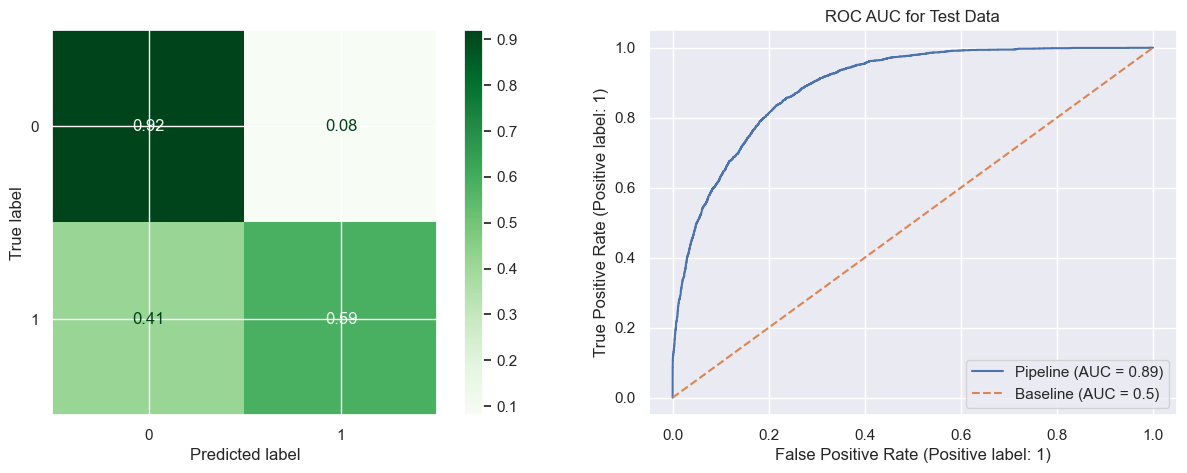

In [58]:
model = LogisticRegression()
model_pipe = make_pipeline(cols_transformer,model)
model_pipe.fit(X_train, y_train[target].values.ravel())
classification_metrics(model_pipe)

## Analysis

In [136]:
def incomeby(column_name,is50plus):
    dfincome = df[df['income'] == is50plus]
    column_counts = dfincome.groupby(column_name).size().reset_index(name='count')
    column_counts = column_counts.sort_values('count', ascending=False)

    fig, ax = plt.subplots(figsize=(20, 10))
    ax = sns.barplot(data=column_counts, x=column_name, y='count', order=column_counts[column_name])
    plt.xticks(rotation=90)  # Rotating x-axis labels for better readability
    ax.set_title(f'{column_name.capitalize()} Counts for Individuals with Income {" > " if is50plus == 1 else " <= "} 50K', fontsize=20, fontweight='bold')
    ax.set_xlabel(column_name.capitalize(), fontsize=15, fontweight='bold')
    ax.set_ylabel('Count', fontsize=15, fontweight='bold')
    plt.show()

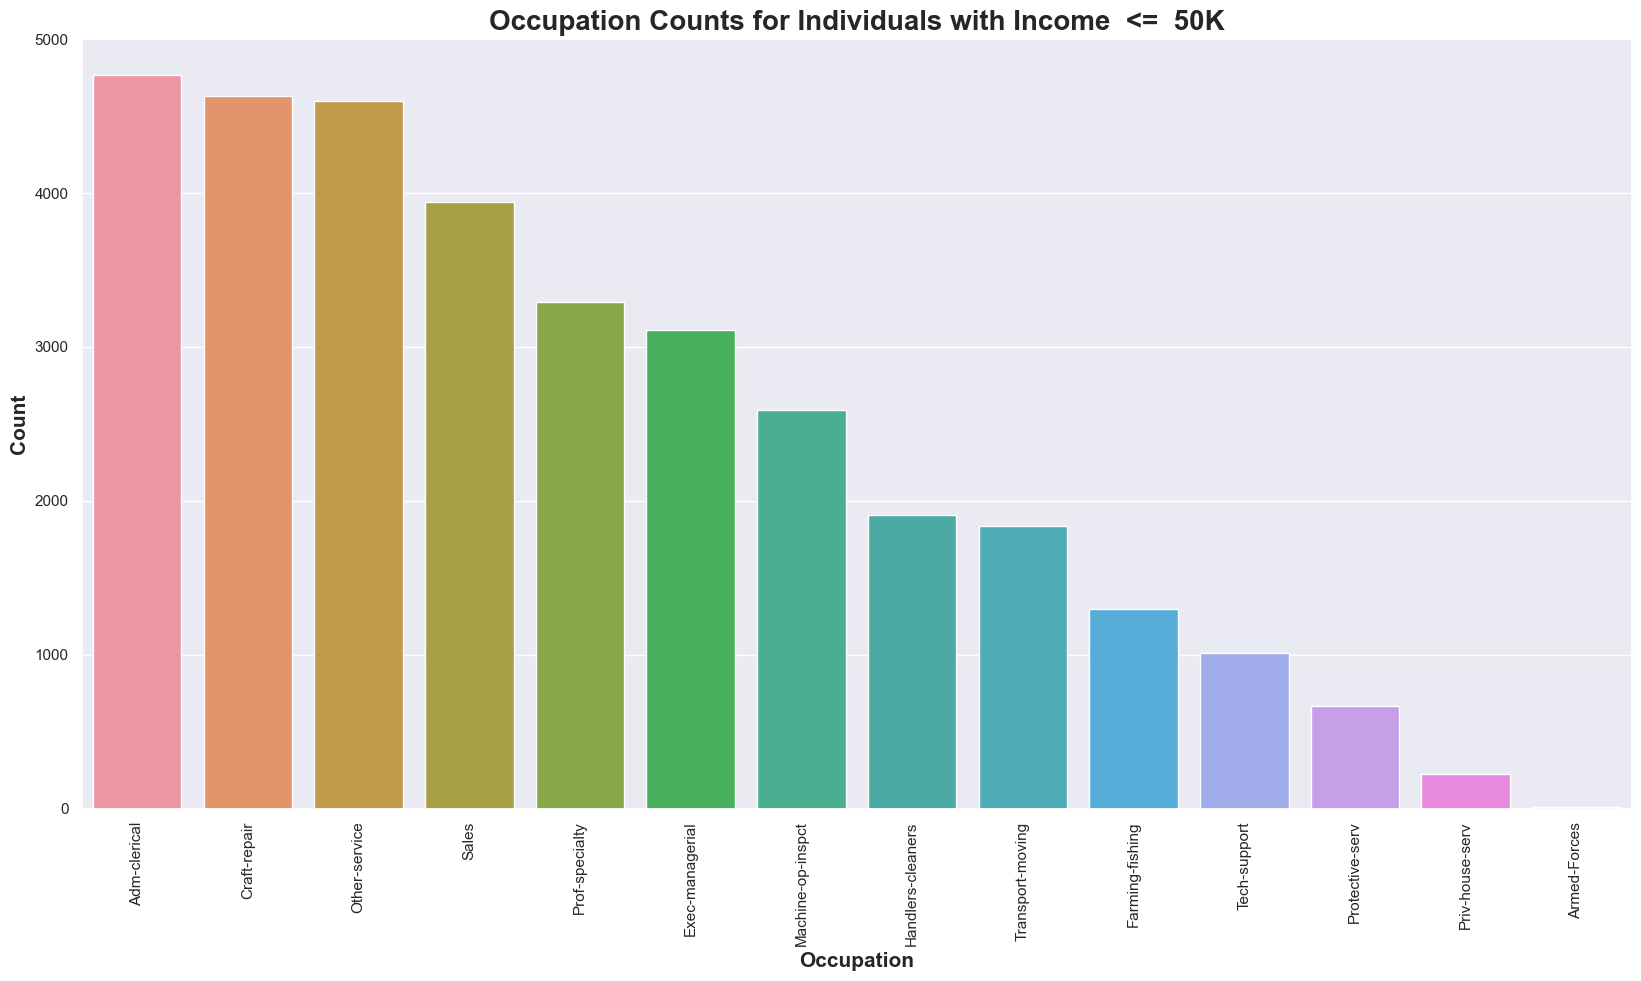

In [137]:
incomeby('occupation', 0)

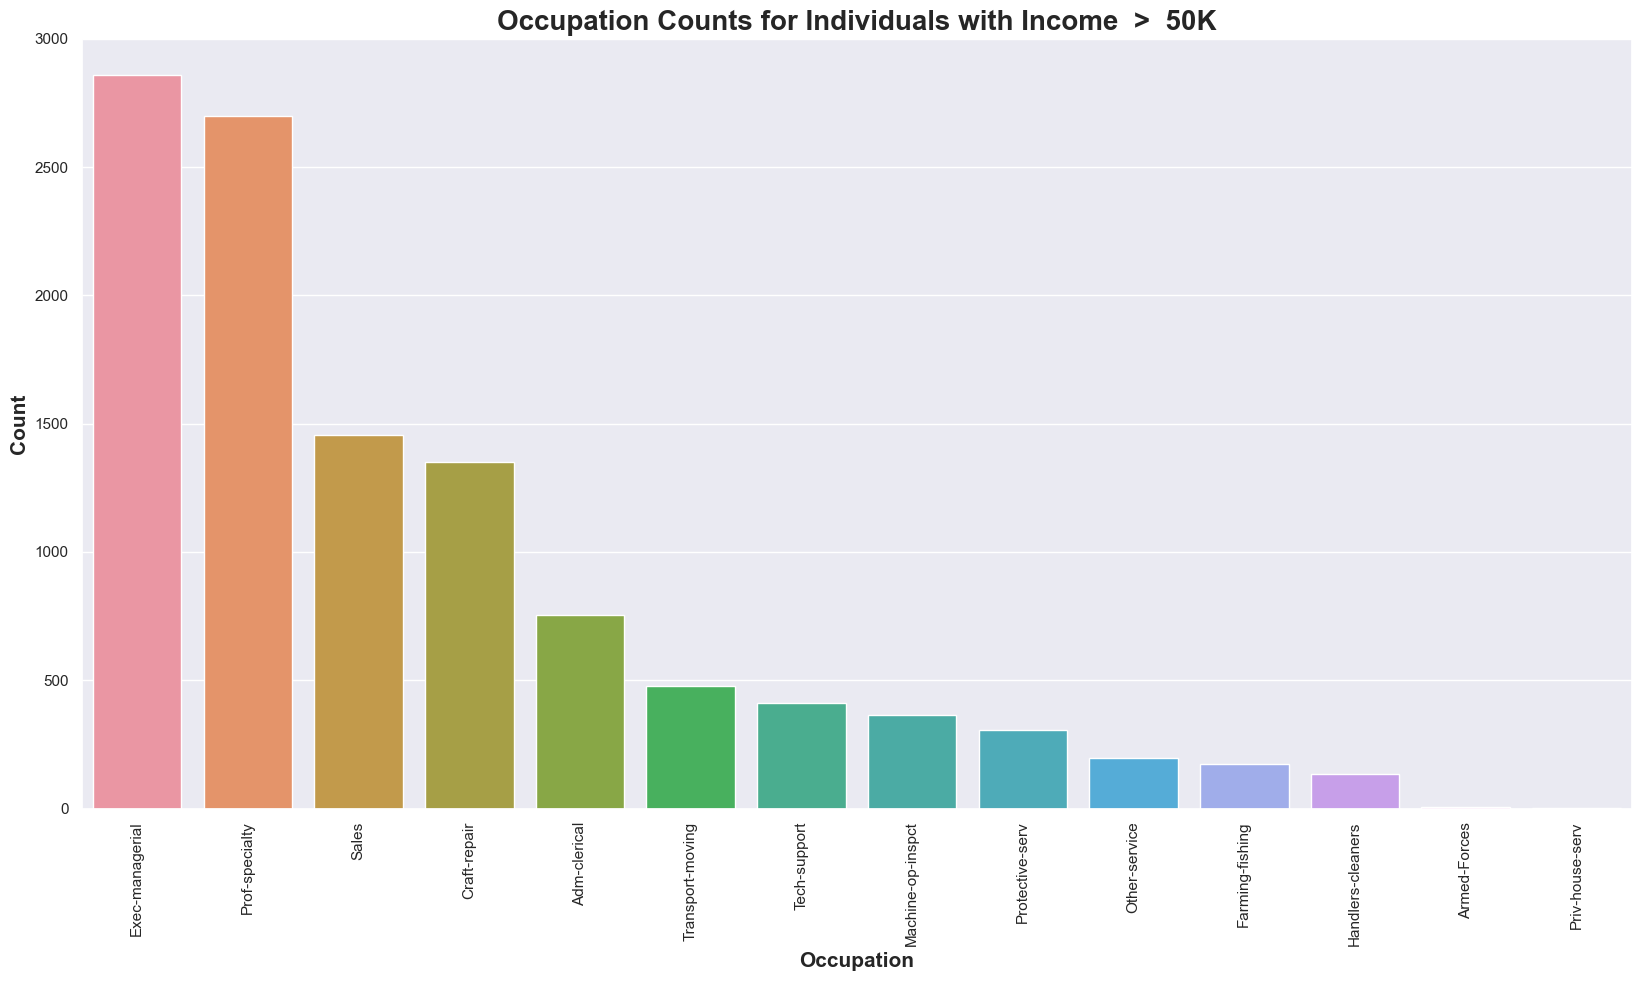

In [138]:
incomeby('occupation', 1)

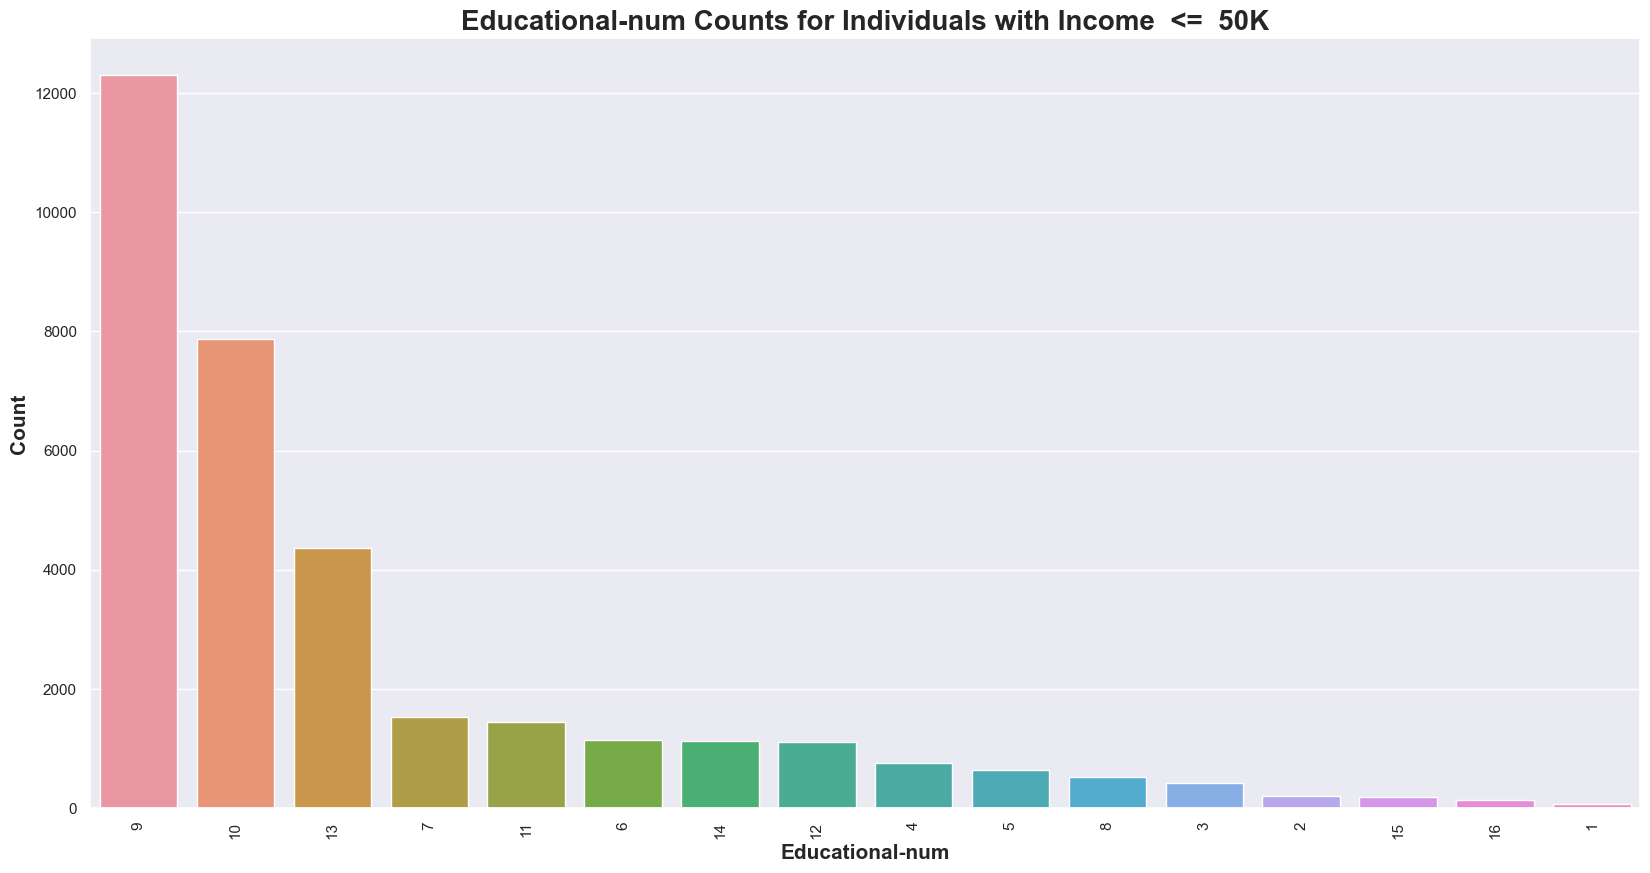

In [140]:
incomeby('educational-num', 0)

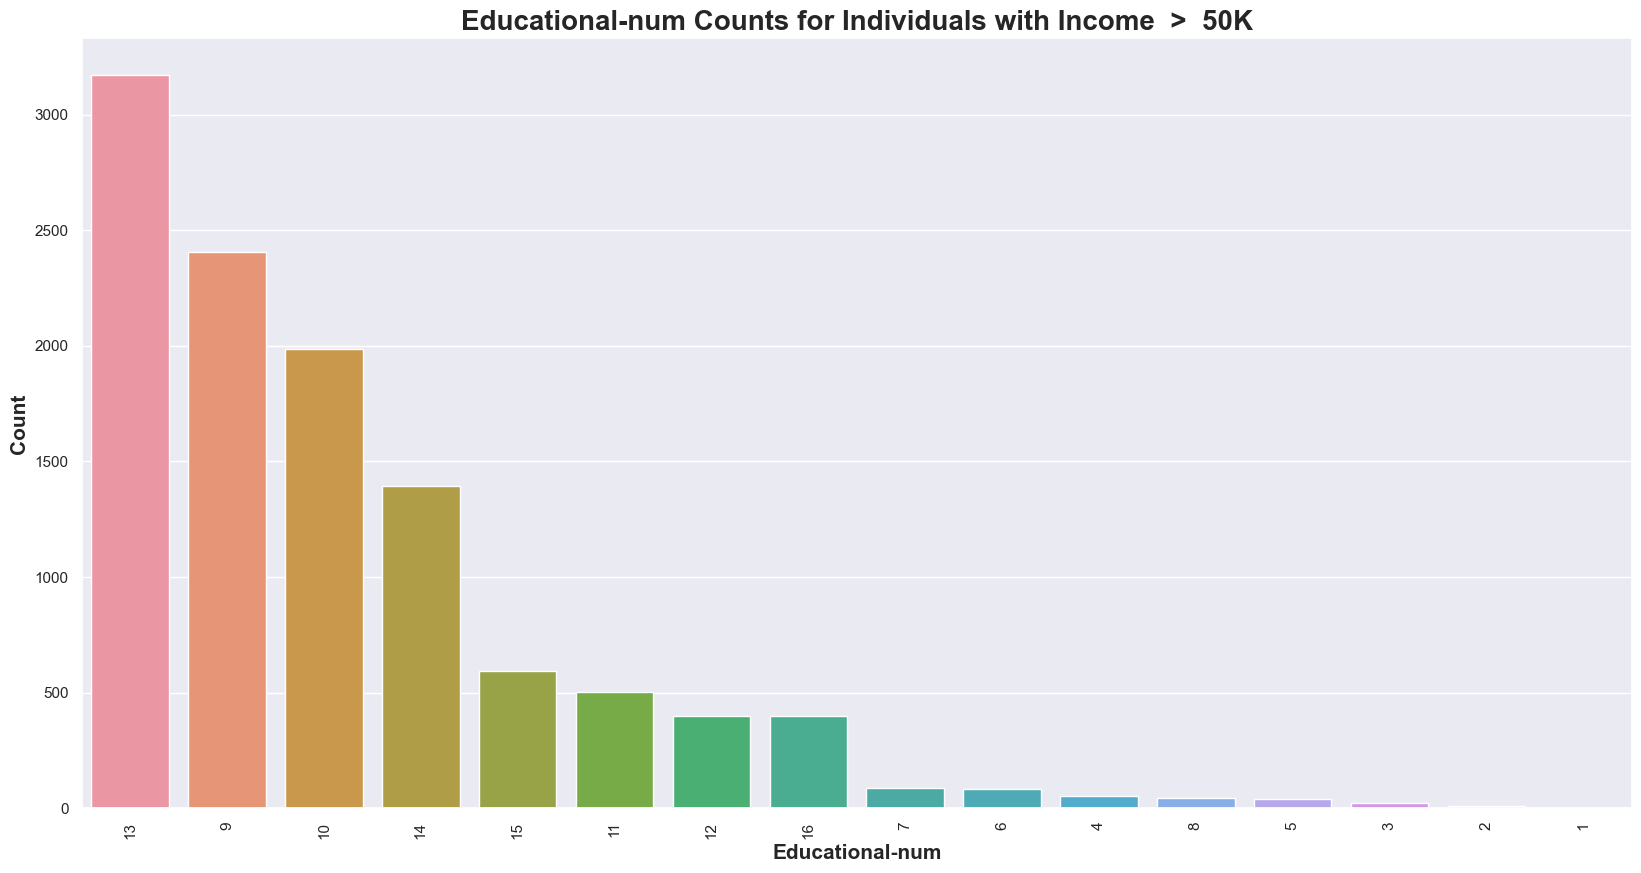

In [141]:
incomeby('educational-num', 1)

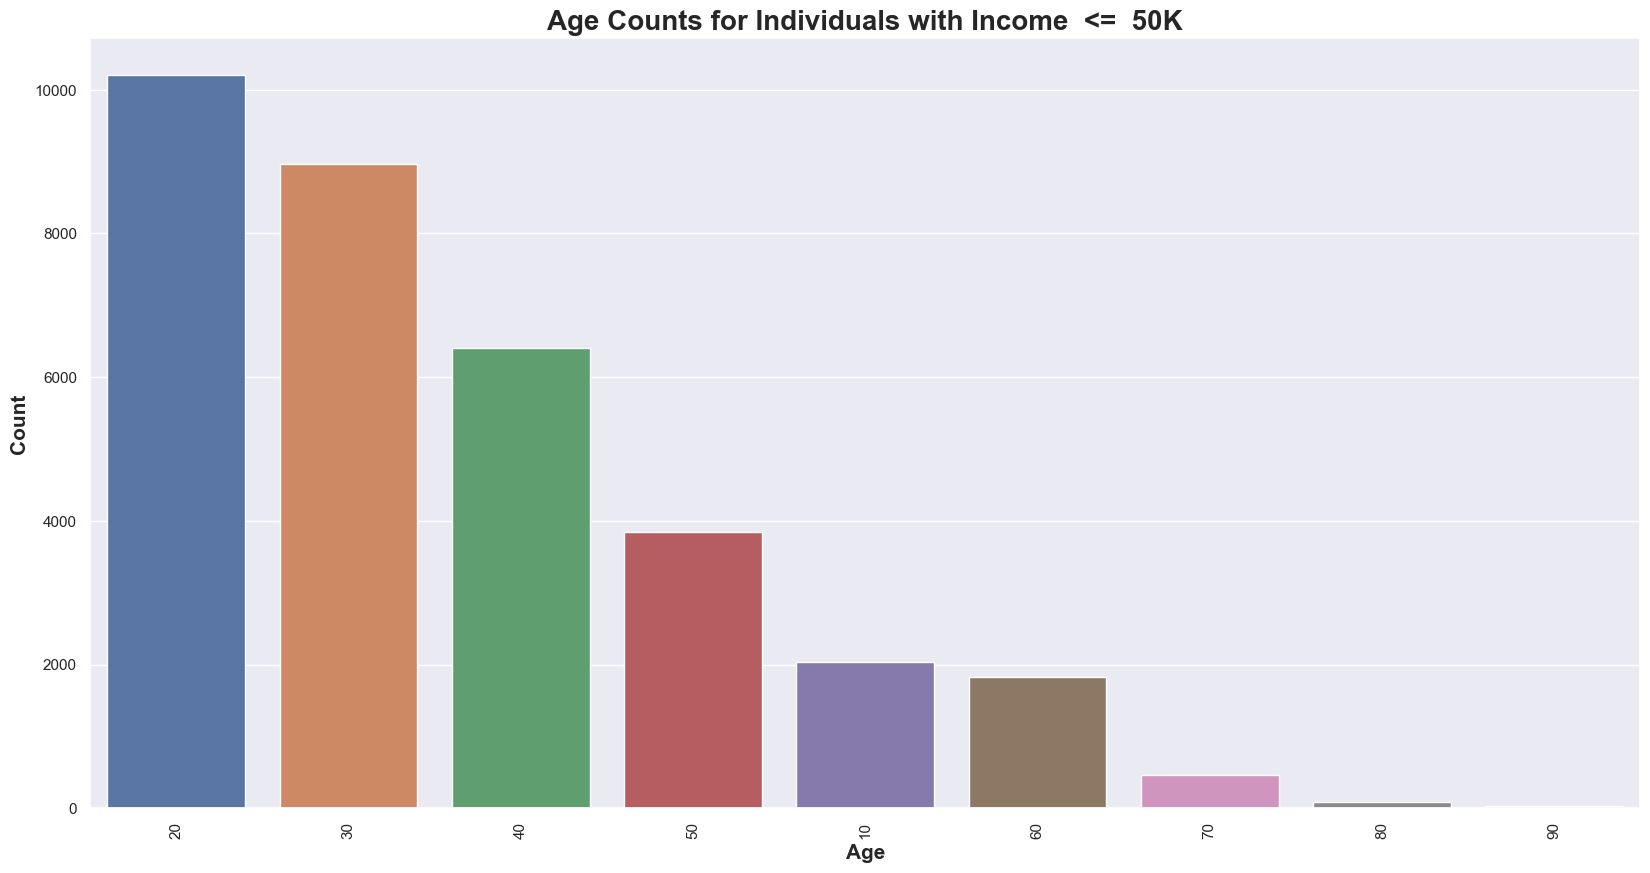

In [142]:
incomeby('age', 0)

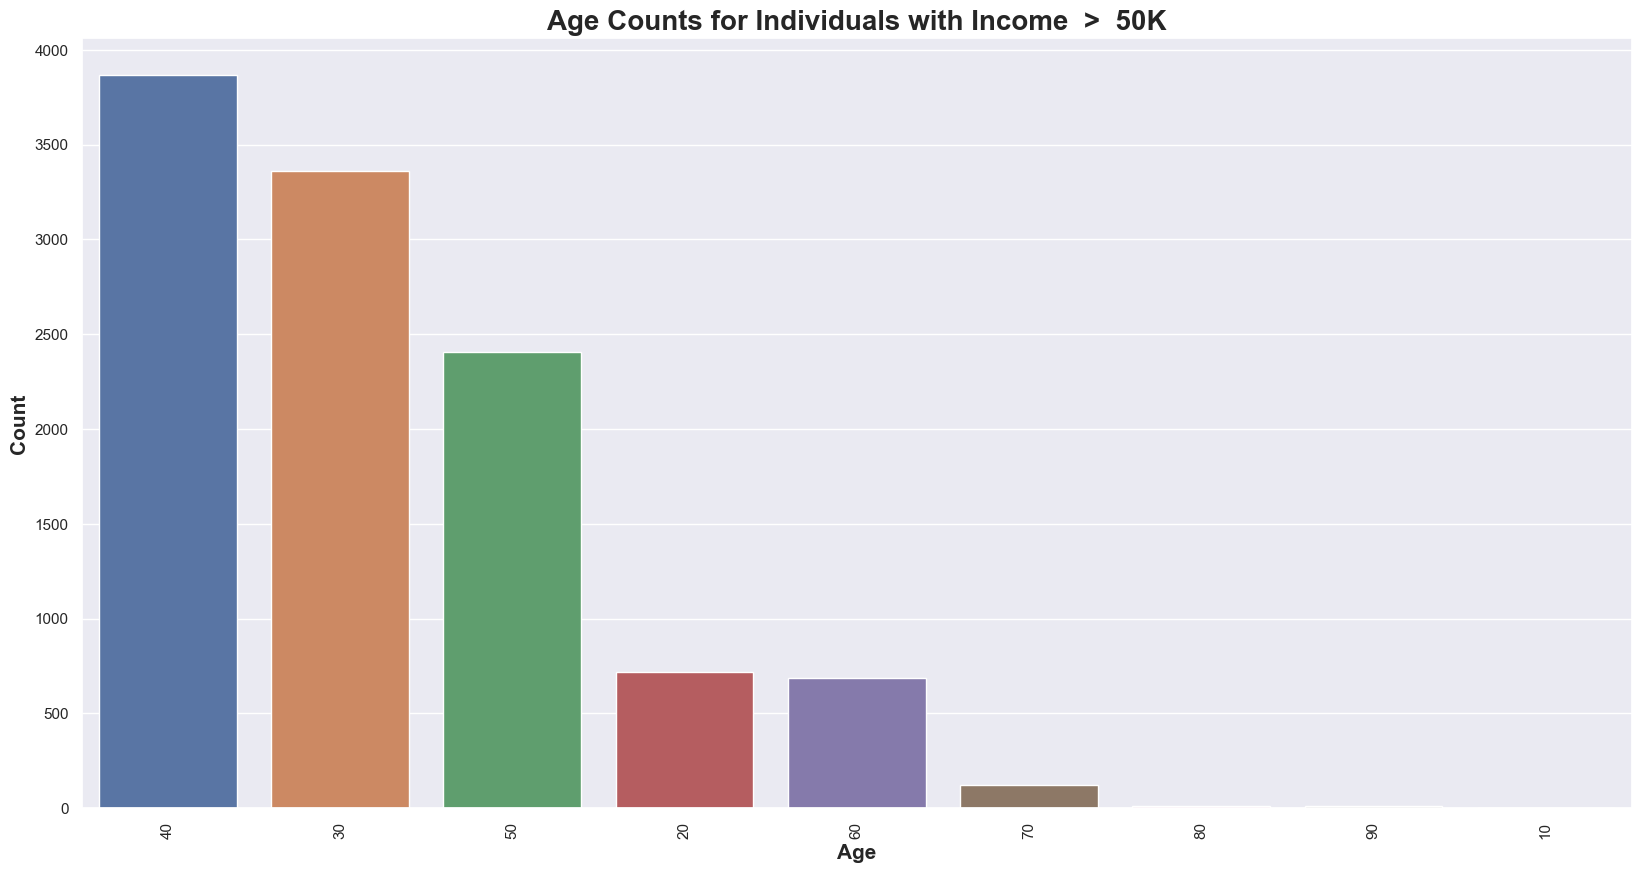

In [143]:
incomeby('age', 1)

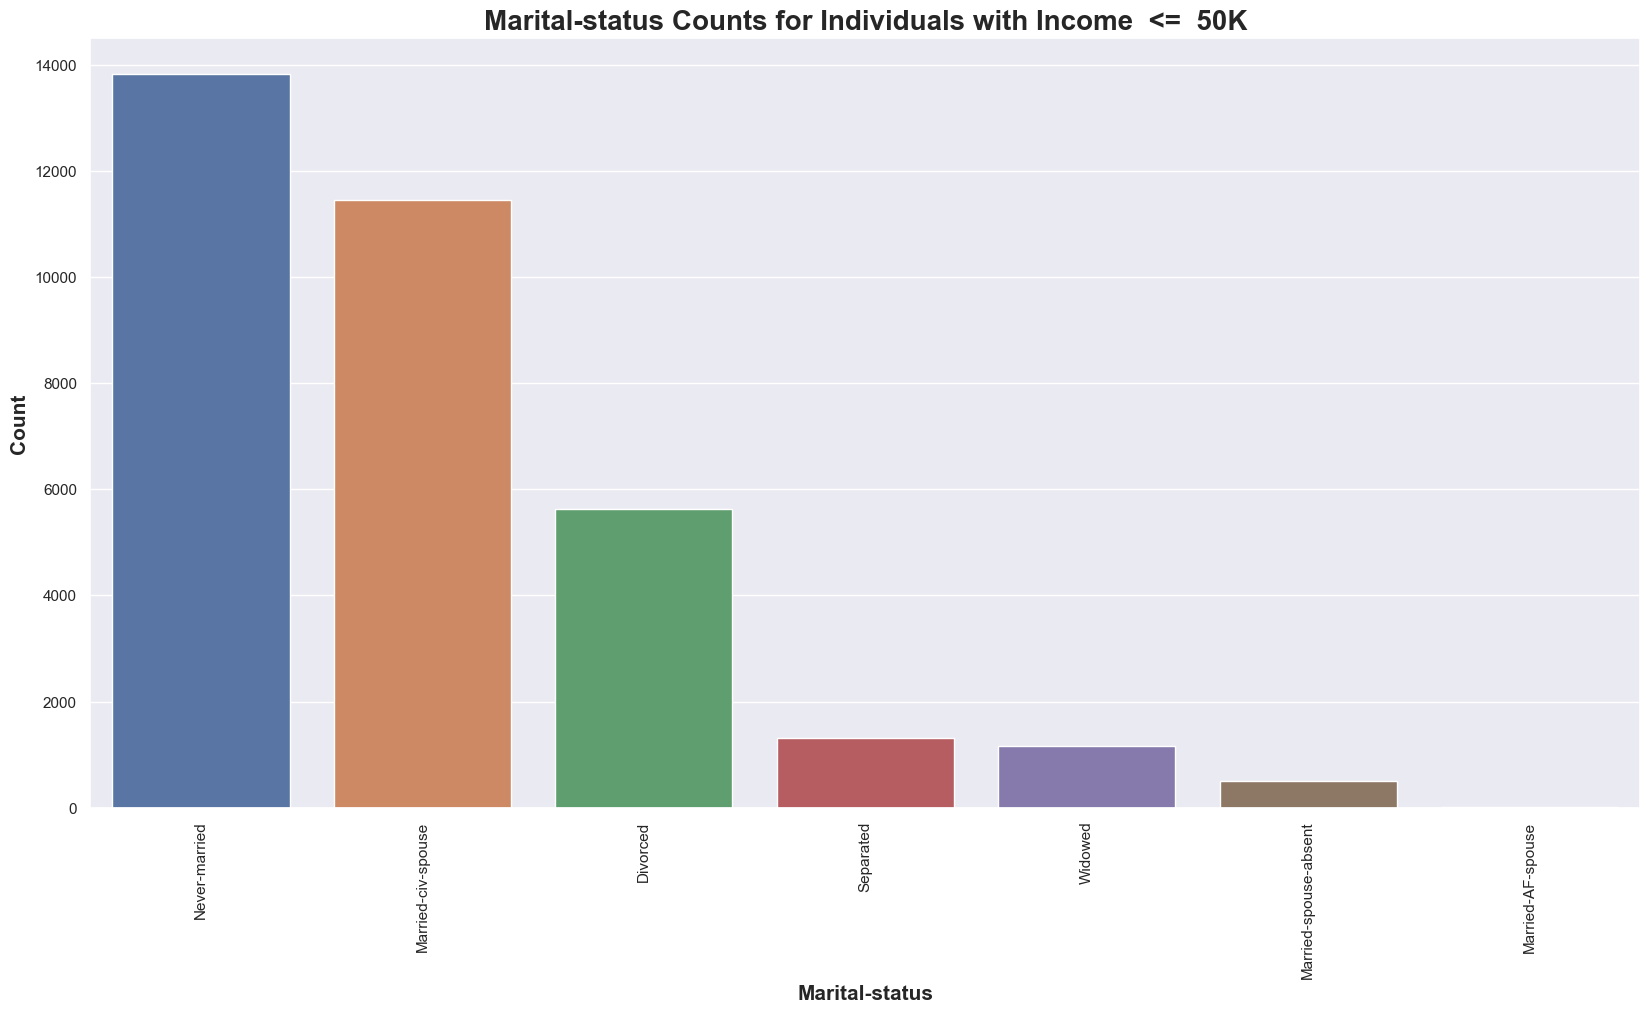

In [146]:
incomeby('marital-status', 0)

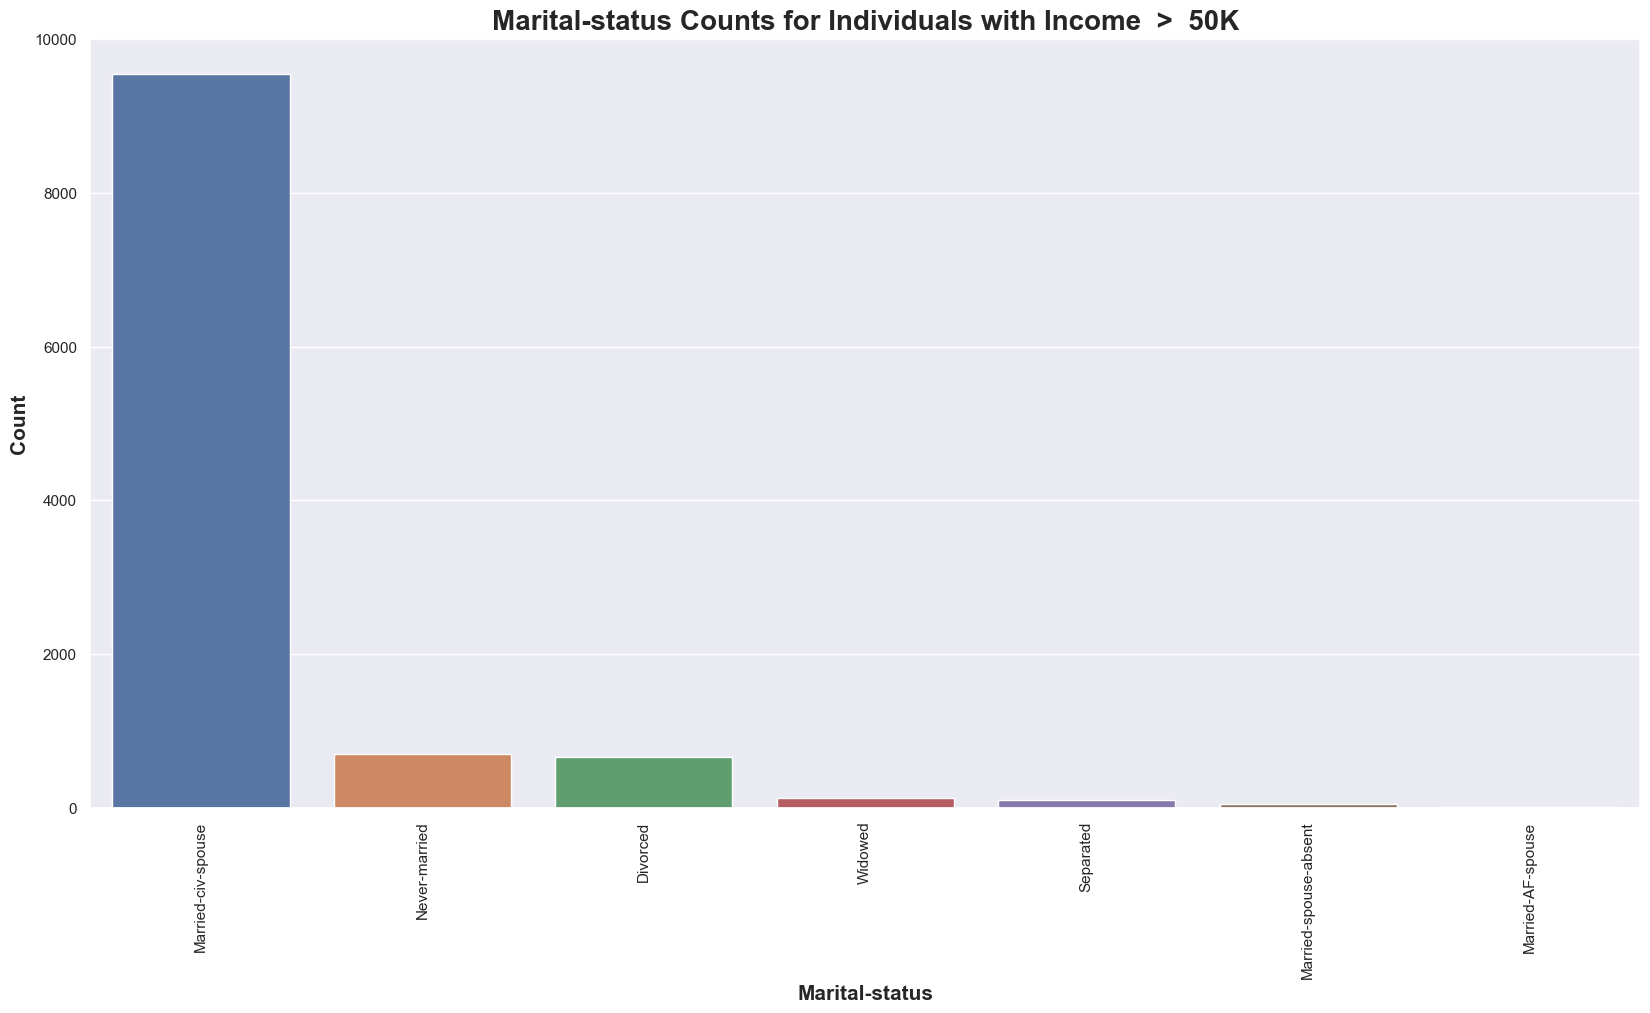

In [147]:
incomeby('marital-status', 1)